In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
#downloading the datasets
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown
url = "https://drive.google.com/u/0/uc?id=19QawTR73YtVd2-qnFbWFb0s5HFDhnsgx&export=download"
output = "data_gaussian_1024.zip"
gdown.download(url, output)
!unzip data_gaussian_1024.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=19QawTR73YtVd2-qnFbWFb0s5HFDhnsgx&export=download
From (redirected): https://drive.google.com/uc?id=19QawTR73YtVd2-qnFbWFb0s5HFDhnsgx&export=download&confirm=t&uuid=c24cd775-53d3-4feb-bf0c-4e0d0d05e728
To: /content/data_gaussian_1024.zip
100%|██████████| 95.5M/95.5M [00:05<00:00, 16.6MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data_gaussian_1024/jammed_channel/images/2_104.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_105.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_106.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_107.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_108.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_109.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_110.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_111.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_112.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_113.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_114.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_115.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_116.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_117.png  
  inflating: data_gaussian

In [3]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data_gaussian_1024")):
  print(folder)
  for im in tqdm(os.listdir("data_gaussian_1024/"+folder+"/images/")):
      if folder == "clean":
          clean.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_clean.append(0)
      elif folder == "clean_validation":
          val.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_val.append(0)
      elif folder== "jammed_channel":
          anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_anomalies.append(1)
      else:
        test.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
        labels_test.append(mapping[int(im[0])])
  ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                    

  0%|          | 0/4 [00:00<?, ?it/s]

clean



 25%|██▌       | 1/4 [00:22<01:06, 22.17s/it]

jammed_channel



 50%|█████     | 2/4 [00:25<00:22, 11.24s/it]

test



 75%|███████▌  | 3/4 [00:29<00:07,  7.96s/it]

clean_validation



100%|██████████| 4/4 [00:32<00:00,  8.14s/it]


In [4]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [5]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

Summary of the encoder:



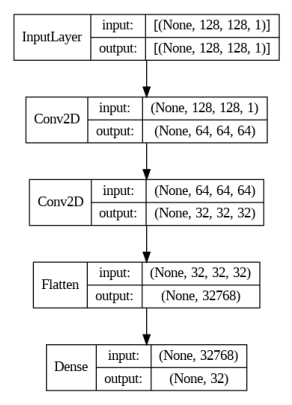

Summary of the decoder:



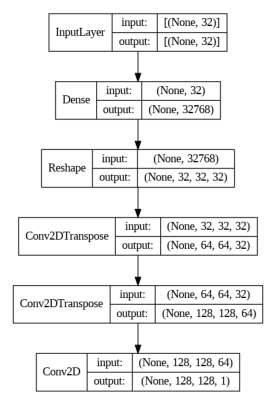

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [7]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 19s 48ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 2/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 3/20
125/125 [==============================] - 6s 48ms/step - loss: 0.0145 - val_loss: 0.0148
Epoch 4/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0144 - val_loss: 0.0147
Epoch 5/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0127 - val_loss: 0.0111
Epoch 6/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 7/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 8/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 9/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 10/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0107 - val_l

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

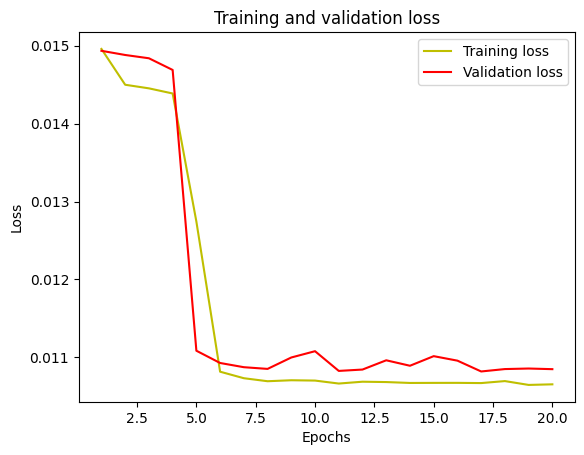

In [8]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 0s 20ms/step


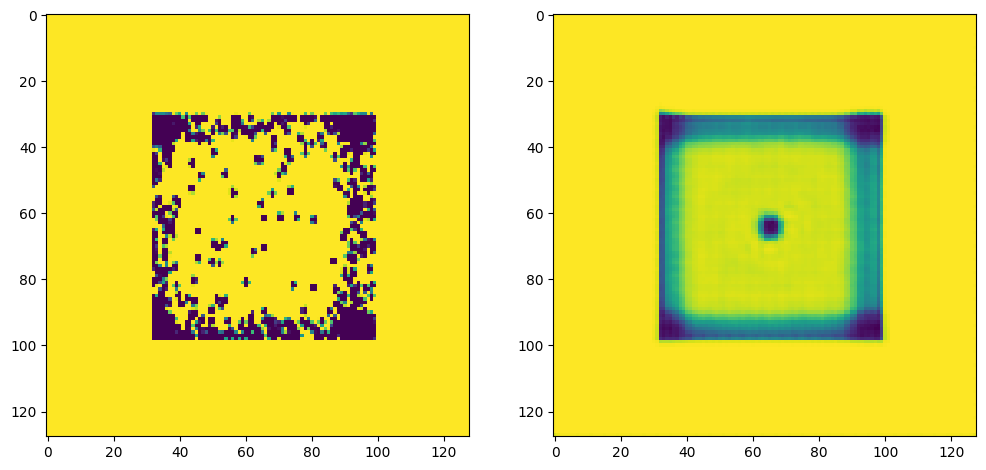

In [12]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [13]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 45ms/step - loss: 0.0529
Validation error 0.010848302394151688
Anomaly error 0.0528927706182003
The reconstruction error of the jammed channel is  4.875672588801982  more than the clean channel


In [14]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list))
    maximum= max(recon_error_list) 
    minimum= min(recon_error_list)
    
    return average_recon_error, stdev_recon_error, maximum, minimum

In [15]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step - loss: 0.0155


  0%|          | 1/600 [00:00<03:36,  2.77it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0190


  0%|          | 2/600 [00:00<03:17,  3.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0174


  1%|          | 4/600 [00:00<01:37,  6.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


  1%|          | 6/600 [00:00<01:09,  8.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


  1%|▏         | 8/600 [00:01<00:58, 10.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


  2%|▏         | 10/600 [00:01<00:53, 10.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0171


  2%|▏         | 12/600 [00:01<00:49, 11.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0150


  2%|▏         | 14/600 [00:01<00:45, 12.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


  3%|▎         | 16/600 [00:01<00:43, 13.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0163


  3%|▎         | 18/600 [00:01<00:44, 13.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0195


  3%|▎         | 20/600 [00:01<00:43, 13.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


  4%|▎         | 22/600 [00:02<00:42, 13.64it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0040


  4%|▍         | 24/600 [00:02<00:42, 13.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


  4%|▍         | 26/600 [00:02<00:41, 13.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0046


  5%|▍         | 28/600 [00:02<00:42, 13.34it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0148


  5%|▌         | 30/600 [00:02<00:42, 13.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0172


  5%|▌         | 32/600 [00:02<00:41, 13.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0178


  6%|▌         | 34/600 [00:02<00:41, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0152


  6%|▌         | 36/600 [00:03<00:41, 13.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0040


  6%|▋         | 38/600 [00:03<00:40, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0046


  7%|▋         | 40/600 [00:03<00:40, 13.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


  7%|▋         | 42/600 [00:03<00:38, 14.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0170


  7%|▋         | 44/600 [00:03<00:38, 14.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


  8%|▊         | 46/600 [00:03<00:38, 14.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0168


  8%|▊         | 48/600 [00:03<00:38, 14.16it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0143


  8%|▊         | 50/600 [00:04<00:39, 14.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


  9%|▊         | 52/600 [00:04<00:39, 13.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0045


  9%|▉         | 54/600 [00:04<00:37, 14.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0170


  9%|▉         | 56/600 [00:04<00:37, 14.58it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0039


 10%|▉         | 58/600 [00:04<00:41, 13.11it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0039


 10%|█         | 60/600 [00:04<00:46, 11.66it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0177


 10%|█         | 62/600 [00:05<00:48, 11.10it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0039


 11%|█         | 64/600 [00:05<00:51, 10.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0168


 11%|█         | 66/600 [00:05<00:51, 10.45it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0173


 11%|█▏        | 68/600 [00:05<00:51, 10.29it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0174


 12%|█▏        | 70/600 [00:05<00:51, 10.25it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0165


 12%|█▏        | 72/600 [00:06<00:51, 10.30it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0155


 12%|█▏        | 74/600 [00:06<00:51, 10.28it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0045


 13%|█▎        | 76/600 [00:06<00:51, 10.21it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0039


 13%|█▎        | 78/600 [00:06<00:52,  9.88it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0157


 13%|█▎        | 79/600 [00:06<00:52,  9.87it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0158


 14%|█▎        | 81/600 [00:07<00:51, 10.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 14%|█▍        | 83/600 [00:07<00:46, 11.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0046


 14%|█▍        | 85/600 [00:07<00:42, 12.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0173


 14%|█▍        | 87/600 [00:07<00:40, 12.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0039


 15%|█▍        | 89/600 [00:07<00:40, 12.57it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0174


 15%|█▌        | 91/600 [00:07<00:38, 13.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0192


 16%|█▌        | 93/600 [00:07<00:36, 13.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0048


 16%|█▌        | 95/600 [00:07<00:35, 14.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 16%|█▌        | 97/600 [00:08<00:35, 14.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0178


 16%|█▋        | 99/600 [00:08<00:35, 14.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0046


 17%|█▋        | 101/600 [00:08<00:35, 13.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 17%|█▋        | 103/600 [00:08<00:35, 14.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0170


 18%|█▊        | 105/600 [00:08<00:33, 14.67it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0180


 18%|█▊        | 107/600 [00:08<00:36, 13.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0177


 18%|█▊        | 109/600 [00:09<00:37, 13.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0166


 18%|█▊        | 111/600 [00:09<00:35, 13.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0046


 19%|█▉        | 113/600 [00:09<00:34, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0170


 19%|█▉        | 115/600 [00:09<00:34, 13.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0172


 20%|█▉        | 117/600 [00:09<00:34, 13.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0044


 20%|█▉        | 119/600 [00:09<00:33, 14.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 20%|██        | 121/600 [00:09<00:33, 14.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 20%|██        | 123/600 [00:09<00:32, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 21%|██        | 125/600 [00:10<00:32, 14.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0044


 21%|██        | 127/600 [00:10<00:31, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 22%|██▏       | 129/600 [00:10<00:31, 14.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 22%|██▏       | 131/600 [00:10<00:31, 14.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0167


 22%|██▏       | 133/600 [00:10<00:32, 14.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0165


 22%|██▎       | 135/600 [00:10<00:31, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0167


 23%|██▎       | 137/600 [00:10<00:31, 14.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0046


 23%|██▎       | 139/600 [00:11<00:31, 14.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0165


 24%|██▎       | 141/600 [00:11<00:30, 14.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0150


 24%|██▍       | 143/600 [00:11<00:30, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0046


 24%|██▍       | 145/600 [00:11<00:31, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 24%|██▍       | 147/600 [00:11<00:31, 14.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 25%|██▍       | 149/600 [00:11<00:31, 14.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0046


 25%|██▌       | 151/600 [00:11<00:31, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 26%|██▌       | 153/600 [00:12<00:31, 14.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0172


 26%|██▌       | 155/600 [00:12<00:30, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0040


 26%|██▌       | 157/600 [00:12<00:31, 13.90it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0039


 26%|██▋       | 159/600 [00:12<00:31, 13.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 27%|██▋       | 161/600 [00:12<00:32, 13.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 27%|██▋       | 163/600 [00:12<00:32, 13.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0039


 28%|██▊       | 165/600 [00:12<00:33, 12.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 28%|██▊       | 167/600 [00:13<00:32, 13.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 28%|██▊       | 169/600 [00:13<00:31, 13.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0048


 28%|██▊       | 171/600 [00:13<00:32, 13.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 29%|██▉       | 173/600 [00:13<00:32, 13.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 29%|██▉       | 175/600 [00:13<00:31, 13.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0161


 30%|██▉       | 177/600 [00:13<00:31, 13.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0045


 30%|██▉       | 179/600 [00:13<00:31, 13.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0152


 30%|███       | 181/600 [00:14<00:30, 13.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


 30%|███       | 183/600 [00:14<00:29, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0166


 31%|███       | 185/600 [00:14<00:30, 13.83it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0172


 31%|███       | 187/600 [00:14<00:30, 13.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0039


 32%|███▏      | 189/600 [00:14<00:30, 13.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 32%|███▏      | 191/600 [00:14<00:29, 14.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 32%|███▏      | 193/600 [00:14<00:28, 14.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0167


 32%|███▎      | 195/600 [00:15<00:28, 14.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0039


 33%|███▎      | 197/600 [00:15<00:28, 13.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 33%|███▎      | 199/600 [00:15<00:28, 14.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 34%|███▎      | 201/600 [00:15<00:28, 14.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0151


 34%|███▍      | 203/600 [00:15<00:27, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0175


 34%|███▍      | 205/600 [00:15<00:28, 14.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0044


 34%|███▍      | 207/600 [00:15<00:28, 13.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 35%|███▍      | 209/600 [00:16<00:27, 14.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 35%|███▌      | 211/600 [00:16<00:27, 14.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0176


 36%|███▌      | 213/600 [00:16<00:27, 13.97it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0134


 36%|███▌      | 215/600 [00:16<00:27, 13.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 36%|███▌      | 217/600 [00:16<00:27, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


 36%|███▋      | 219/600 [00:16<00:26, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0173


 37%|███▋      | 221/600 [00:16<00:26, 14.19it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0047


 37%|███▋      | 223/600 [00:17<00:27, 13.65it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0039


 38%|███▊      | 225/600 [00:17<00:31, 12.05it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0046


 38%|███▊      | 227/600 [00:17<00:32, 11.46it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0177


 38%|███▊      | 229/600 [00:17<00:34, 10.89it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0039


 38%|███▊      | 231/600 [00:17<00:34, 10.60it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0039


 39%|███▉      | 233/600 [00:18<00:35, 10.33it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0039


 39%|███▉      | 235/600 [00:18<00:35, 10.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0134


 40%|███▉      | 237/600 [00:18<00:34, 10.47it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0190


 40%|███▉      | 239/600 [00:18<00:34, 10.40it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0165


 40%|████      | 241/600 [00:18<00:33, 10.59it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0039


 40%|████      | 243/600 [00:19<00:34, 10.35it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0039


 41%|████      | 245/600 [00:19<00:33, 10.51it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0039


 41%|████      | 247/600 [00:19<00:34, 10.33it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0170


 42%|████▏     | 249/600 [00:19<00:34, 10.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0039


 42%|████▏     | 251/600 [00:19<00:32, 10.88it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0195


 42%|████▏     | 253/600 [00:19<00:29, 11.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 42%|████▎     | 255/600 [00:20<00:28, 12.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0040


 43%|████▎     | 257/600 [00:20<00:26, 13.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0133


 43%|████▎     | 259/600 [00:20<00:25, 13.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 44%|████▎     | 261/600 [00:20<00:24, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 44%|████▍     | 263/600 [00:20<00:23, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0136


 44%|████▍     | 265/600 [00:20<00:23, 14.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0045


 44%|████▍     | 267/600 [00:20<00:23, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0164


 45%|████▍     | 269/600 [00:21<00:23, 13.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0039


 45%|████▌     | 271/600 [00:21<00:23, 14.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 46%|████▌     | 273/600 [00:21<00:22, 14.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0395


 46%|████▌     | 275/600 [00:21<00:22, 14.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 46%|████▌     | 277/600 [00:21<00:22, 14.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 46%|████▋     | 279/600 [00:21<00:23, 13.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0150


 47%|████▋     | 281/600 [00:21<00:22, 13.94it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0136


 47%|████▋     | 283/600 [00:22<00:23, 13.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 48%|████▊     | 285/600 [00:22<00:22, 13.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0171


 48%|████▊     | 287/600 [00:22<00:22, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0129


 48%|████▊     | 289/600 [00:22<00:22, 14.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0171


 48%|████▊     | 291/600 [00:22<00:21, 14.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 49%|████▉     | 293/600 [00:22<00:23, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0146


 49%|████▉     | 295/600 [00:22<00:22, 13.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 50%|████▉     | 297/600 [00:23<00:21, 13.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0149


 50%|████▉     | 299/600 [00:23<00:21, 13.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 50%|█████     | 301/600 [00:23<00:21, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 50%|█████     | 303/600 [00:23<00:21, 13.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0165


 51%|█████     | 305/600 [00:23<00:20, 14.16it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0045


 51%|█████     | 307/600 [00:23<00:20, 14.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 52%|█████▏    | 309/600 [00:23<00:20, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0173


 52%|█████▏    | 311/600 [00:24<00:20, 14.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0040


 52%|█████▏    | 313/600 [00:24<00:20, 14.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0133


 52%|█████▎    | 315/600 [00:24<00:19, 14.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 53%|█████▎    | 317/600 [00:24<00:19, 14.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0177


 53%|█████▎    | 319/600 [00:24<00:19, 14.08it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0178


 54%|█████▎    | 321/600 [00:24<00:20, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0158


 54%|█████▍    | 323/600 [00:24<00:20, 13.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 54%|█████▍    | 325/600 [00:25<00:19, 13.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0192


 55%|█████▍    | 327/600 [00:25<00:19, 13.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 55%|█████▍    | 329/600 [00:25<00:19, 14.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0124


 55%|█████▌    | 331/600 [00:25<00:19, 13.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0039


 56%|█████▌    | 333/600 [00:25<00:18, 14.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0039


 56%|█████▌    | 335/600 [00:25<00:19, 13.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 56%|█████▌    | 337/600 [00:25<00:18, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 56%|█████▋    | 339/600 [00:26<00:18, 13.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 57%|█████▋    | 341/600 [00:26<00:18, 13.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0164


 57%|█████▋    | 343/600 [00:26<00:18, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 57%|█████▊    | 345/600 [00:26<00:17, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0161


 58%|█████▊    | 347/600 [00:26<00:17, 14.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0171


 58%|█████▊    | 349/600 [00:26<00:17, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0173


 58%|█████▊    | 351/600 [00:26<00:17, 13.99it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0176


 59%|█████▉    | 353/600 [00:27<00:17, 13.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 59%|█████▉    | 355/600 [00:27<00:17, 13.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 60%|█████▉    | 357/600 [00:27<00:17, 14.09it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0039


 60%|█████▉    | 359/600 [00:27<00:17, 13.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 60%|██████    | 361/600 [00:27<00:17, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 60%|██████    | 363/600 [00:27<00:16, 14.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 61%|██████    | 365/600 [00:27<00:16, 13.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0164


 61%|██████    | 367/600 [00:28<00:16, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 62%|██████▏   | 369/600 [00:28<00:16, 13.95it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0046


 62%|██████▏   | 371/600 [00:28<00:16, 13.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0046


 62%|██████▏   | 373/600 [00:28<00:16, 13.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0422


 62%|██████▎   | 375/600 [00:28<00:16, 13.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0045


 63%|██████▎   | 377/600 [00:28<00:16, 13.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0044


 63%|██████▎   | 379/600 [00:28<00:16, 13.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0165


 64%|██████▎   | 381/600 [00:29<00:16, 13.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0047


 64%|██████▍   | 383/600 [00:29<00:15, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 64%|██████▍   | 385/600 [00:29<00:15, 13.92it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0039


 64%|██████▍   | 387/600 [00:29<00:15, 13.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0045


 65%|██████▍   | 389/600 [00:29<00:15, 13.70it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0039


 65%|██████▌   | 391/600 [00:29<00:17, 12.14it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0152


 66%|██████▌   | 393/600 [00:30<00:18, 11.45it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0186


 66%|██████▌   | 395/600 [00:30<00:18, 11.18it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0178


 66%|██████▌   | 397/600 [00:30<00:18, 11.17it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0039


 66%|██████▋   | 399/600 [00:30<00:18, 10.63it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0039


 67%|██████▋   | 401/600 [00:30<00:19, 10.04it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0039


 67%|██████▋   | 403/600 [00:31<00:19, 10.24it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0393


 68%|██████▊   | 405/600 [00:31<00:20,  9.52it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0163


 68%|██████▊   | 407/600 [00:31<00:19,  9.73it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0039


 68%|██████▊   | 409/600 [00:31<00:19,  9.95it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0039


 68%|██████▊   | 411/600 [00:31<00:19,  9.91it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0040


 69%|██████▉   | 413/600 [00:32<00:18,  9.96it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0039


 69%|██████▉   | 415/600 [00:32<00:18,  9.89it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0049


 69%|██████▉   | 416/600 [00:32<00:19,  9.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0046


 70%|██████▉   | 418/600 [00:32<00:17, 10.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0146


 70%|███████   | 420/600 [00:32<00:15, 11.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 70%|███████   | 422/600 [00:32<00:15, 11.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 71%|███████   | 424/600 [00:33<00:14, 11.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0048


 71%|███████   | 426/600 [00:33<00:13, 12.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 71%|███████▏  | 428/600 [00:33<00:13, 12.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 72%|███████▏  | 430/600 [00:33<00:12, 13.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0044


 72%|███████▏  | 432/600 [00:33<00:12, 13.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 72%|███████▏  | 434/600 [00:33<00:12, 13.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 73%|███████▎  | 436/600 [00:33<00:12, 13.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0136


 73%|███████▎  | 438/600 [00:34<00:12, 13.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 73%|███████▎  | 440/600 [00:34<00:11, 13.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0175


 74%|███████▎  | 442/600 [00:34<00:11, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 74%|███████▍  | 444/600 [00:34<00:11, 13.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0040


 74%|███████▍  | 446/600 [00:34<00:11, 13.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0174


 75%|███████▍  | 448/600 [00:34<00:11, 13.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 75%|███████▌  | 450/600 [00:34<00:11, 13.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 75%|███████▌  | 452/600 [00:35<00:11, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 76%|███████▌  | 454/600 [00:35<00:10, 13.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0040


 76%|███████▌  | 456/600 [00:35<00:10, 13.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0155


 76%|███████▋  | 458/600 [00:35<00:10, 13.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0179


 77%|███████▋  | 460/600 [00:35<00:10, 13.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0158


 77%|███████▋  | 462/600 [00:35<00:09, 14.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0177


 77%|███████▋  | 464/600 [00:35<00:09, 13.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 78%|███████▊  | 466/600 [00:36<00:09, 13.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0163


 78%|███████▊  | 468/600 [00:36<00:09, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0040


 78%|███████▊  | 470/600 [00:36<00:09, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 79%|███████▊  | 472/600 [00:36<00:09, 13.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 79%|███████▉  | 474/600 [00:36<00:08, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 79%|███████▉  | 476/600 [00:36<00:08, 13.86it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0044


 80%|███████▉  | 478/600 [00:36<00:08, 13.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 80%|████████  | 480/600 [00:37<00:08, 13.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0148


 80%|████████  | 482/600 [00:37<00:08, 13.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0175


 81%|████████  | 484/600 [00:37<00:08, 13.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 81%|████████  | 486/600 [00:37<00:08, 13.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0044


 81%|████████▏ | 488/600 [00:37<00:08, 13.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 82%|████████▏ | 490/600 [00:37<00:08, 13.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 82%|████████▏ | 492/600 [00:38<00:07, 13.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0047


 82%|████████▏ | 494/600 [00:38<00:07, 13.38it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 83%|████████▎ | 496/600 [00:38<00:07, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 83%|████████▎ | 498/600 [00:38<00:07, 13.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 83%|████████▎ | 500/600 [00:38<00:07, 13.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0170


 84%|████████▎ | 502/600 [00:38<00:07, 13.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 84%|████████▍ | 504/600 [00:38<00:07, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 84%|████████▍ | 506/600 [00:39<00:07, 13.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0045


 85%|████████▍ | 508/600 [00:39<00:06, 13.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0136


 85%|████████▌ | 510/600 [00:39<00:06, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0046


 85%|████████▌ | 512/600 [00:39<00:06, 13.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 86%|████████▌ | 514/600 [00:39<00:06, 13.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 86%|████████▌ | 516/600 [00:39<00:06, 13.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0171


 86%|████████▋ | 518/600 [00:39<00:06, 13.21it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0175


 87%|████████▋ | 520/600 [00:40<00:06, 12.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0182


 87%|████████▋ | 522/600 [00:40<00:05, 13.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 87%|████████▋ | 524/600 [00:40<00:06, 12.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0040


 88%|████████▊ | 526/600 [00:40<00:05, 12.99it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0039


 88%|████████▊ | 528/600 [00:40<00:05, 13.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0172


 88%|████████▊ | 530/600 [00:40<00:05, 13.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 89%|████████▊ | 532/600 [00:41<00:05, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0046


 89%|████████▉ | 534/600 [00:41<00:04, 13.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0040


 89%|████████▉ | 536/600 [00:41<00:04, 13.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 90%|████████▉ | 538/600 [00:41<00:04, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 90%|█████████ | 540/600 [00:41<00:04, 13.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0155


 90%|█████████ | 542/600 [00:41<00:04, 13.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0039


 91%|█████████ | 544/600 [00:41<00:04, 13.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0040


 91%|█████████ | 546/600 [00:42<00:03, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0045


 91%|█████████▏| 548/600 [00:42<00:04, 12.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0168


 92%|█████████▏| 550/600 [00:42<00:03, 13.35it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0039


 92%|█████████▏| 552/600 [00:42<00:03, 12.22it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0039


 92%|█████████▏| 554/600 [00:42<00:04, 11.35it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0173


 93%|█████████▎| 556/600 [00:42<00:03, 11.17it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0039


 93%|█████████▎| 558/600 [00:43<00:03, 11.12it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0184


 93%|█████████▎| 560/600 [00:43<00:03, 10.80it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0185


 94%|█████████▎| 562/600 [00:43<00:03, 10.68it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0040


 94%|█████████▍| 564/600 [00:43<00:03, 10.66it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0039


 94%|█████████▍| 566/600 [00:43<00:03, 10.84it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0161


 95%|█████████▍| 568/600 [00:44<00:03, 10.23it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0179


 95%|█████████▌| 570/600 [00:44<00:02, 10.29it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0039


 95%|█████████▌| 572/600 [00:44<00:02, 10.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0039


 96%|█████████▌| 574/600 [00:44<00:02, 10.73it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0173


 96%|█████████▌| 576/600 [00:44<00:02, 10.14it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0163


 96%|█████████▋| 578/600 [00:45<00:02,  9.96it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0039


 97%|█████████▋| 580/600 [00:45<00:01, 10.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0176


 97%|█████████▋| 582/600 [00:45<00:01, 10.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0145


 97%|█████████▋| 584/600 [00:45<00:01, 11.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 98%|█████████▊| 586/600 [00:45<00:01, 12.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0179


 98%|█████████▊| 588/600 [00:45<00:00, 12.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0039


 98%|█████████▊| 590/600 [00:46<00:00, 12.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0159


 99%|█████████▊| 592/600 [00:46<00:00, 12.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 99%|█████████▉| 594/600 [00:46<00:00, 13.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0045


 99%|█████████▉| 596/600 [00:46<00:00, 13.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0164


100%|█████████▉| 598/600 [00:46<00:00, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0045


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0547


  0%|          | 2/500 [00:00<00:37, 13.24it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0504


  1%|          | 4/500 [00:00<00:35, 14.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0545


  1%|          | 6/500 [00:00<00:35, 14.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0522


  2%|▏         | 8/500 [00:00<00:36, 13.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0533


  2%|▏         | 10/500 [00:00<00:36, 13.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0539


  2%|▏         | 12/500 [00:00<00:36, 13.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0541


  3%|▎         | 14/500 [00:01<00:36, 13.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0529


  3%|▎         | 16/500 [00:01<00:37, 12.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0521


  4%|▎         | 18/500 [00:01<00:37, 12.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0482


  4%|▍         | 20/500 [00:01<00:35, 13.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0527


  4%|▍         | 22/500 [00:01<00:35, 13.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0535


  5%|▍         | 24/500 [00:01<00:35, 13.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0529


  5%|▌         | 26/500 [00:01<00:35, 13.39it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0539


  6%|▌         | 28/500 [00:02<00:34, 13.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0547


  6%|▌         | 30/500 [00:02<00:35, 13.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0555


  6%|▋         | 32/500 [00:02<00:35, 13.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0549


  7%|▋         | 34/500 [00:02<00:34, 13.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0527


  7%|▋         | 36/500 [00:02<00:34, 13.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0527


  8%|▊         | 38/500 [00:02<00:34, 13.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0541


  8%|▊         | 40/500 [00:02<00:34, 13.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0531


  8%|▊         | 42/500 [00:03<00:33, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0525


  9%|▉         | 44/500 [00:03<00:36, 12.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0528


  9%|▉         | 46/500 [00:03<00:36, 12.50it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0531


 10%|▉         | 48/500 [00:03<00:35, 12.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0541


 10%|█         | 50/500 [00:03<00:35, 12.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0536


 10%|█         | 52/500 [00:03<00:34, 12.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0520


 11%|█         | 54/500 [00:04<00:33, 13.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0538


 11%|█         | 56/500 [00:04<00:33, 13.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0531


 12%|█▏        | 58/500 [00:04<00:33, 13.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0531


 12%|█▏        | 60/500 [00:04<00:33, 13.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0534


 12%|█▏        | 62/500 [00:04<00:32, 13.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0531


 13%|█▎        | 64/500 [00:04<00:32, 13.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0528


 13%|█▎        | 66/500 [00:04<00:33, 12.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0525


 14%|█▎        | 68/500 [00:05<00:32, 13.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0453


 14%|█▍        | 70/500 [00:05<00:32, 13.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0464


 14%|█▍        | 72/500 [00:05<00:31, 13.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0549


 15%|█▍        | 74/500 [00:05<00:32, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0524


 15%|█▌        | 76/500 [00:05<00:32, 13.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0535


 16%|█▌        | 78/500 [00:05<00:31, 13.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0543


 16%|█▌        | 80/500 [00:06<00:32, 12.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0545


 16%|█▋        | 82/500 [00:06<00:32, 12.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0533


 17%|█▋        | 84/500 [00:06<00:31, 13.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0528


 17%|█▋        | 86/500 [00:06<00:30, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0533


 18%|█▊        | 88/500 [00:06<00:30, 13.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0523


 18%|█▊        | 90/500 [00:06<00:31, 13.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0536


 18%|█▊        | 92/500 [00:06<00:31, 12.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0542


 19%|█▉        | 94/500 [00:07<00:31, 13.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0530


 19%|█▉        | 96/500 [00:07<00:30, 13.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0532


 20%|█▉        | 98/500 [00:07<00:29, 13.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0550


 20%|██        | 100/500 [00:07<00:29, 13.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0528


 20%|██        | 102/500 [00:07<00:29, 13.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0530


 21%|██        | 104/500 [00:07<00:29, 13.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0527


 21%|██        | 106/500 [00:07<00:29, 13.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0531


 22%|██▏       | 108/500 [00:08<00:29, 13.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0540


 22%|██▏       | 110/500 [00:08<00:29, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0528


 22%|██▏       | 112/500 [00:08<00:28, 13.40it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0541


 23%|██▎       | 114/500 [00:08<00:29, 13.24it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0536


 23%|██▎       | 116/500 [00:08<00:33, 11.43it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0533


 24%|██▎       | 118/500 [00:09<00:34, 11.02it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0523


 24%|██▍       | 120/500 [00:09<00:35, 10.80it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0518


 24%|██▍       | 122/500 [00:09<00:36, 10.49it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0526


 25%|██▍       | 124/500 [00:09<00:36, 10.39it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0529


 25%|██▌       | 126/500 [00:09<00:37,  9.92it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0532


 26%|██▌       | 128/500 [00:10<00:37,  9.93it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0528


 26%|██▌       | 130/500 [00:10<00:37,  9.74it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0530


 26%|██▌       | 131/500 [00:10<00:38,  9.67it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0535


 26%|██▋       | 132/500 [00:10<00:38,  9.63it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0519


 27%|██▋       | 133/500 [00:10<00:38,  9.59it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0467


 27%|██▋       | 135/500 [00:10<00:37,  9.67it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0538


 27%|██▋       | 137/500 [00:11<00:39,  9.19it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0535


 28%|██▊       | 138/500 [00:11<00:39,  9.15it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0531


 28%|██▊       | 139/500 [00:11<00:40,  8.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0541


 28%|██▊       | 141/500 [00:11<00:34, 10.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0525


 29%|██▊       | 143/500 [00:11<00:32, 11.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0539


 29%|██▉       | 145/500 [00:11<00:29, 12.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0544


 29%|██▉       | 147/500 [00:11<00:28, 12.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0458


 30%|██▉       | 149/500 [00:11<00:27, 12.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0520


 30%|███       | 151/500 [00:12<00:26, 13.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0528


 31%|███       | 153/500 [00:12<00:26, 13.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0530


 31%|███       | 155/500 [00:12<00:26, 13.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0534


 31%|███▏      | 157/500 [00:12<00:25, 13.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0533


 32%|███▏      | 159/500 [00:12<00:25, 13.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0525


 32%|███▏      | 161/500 [00:12<00:25, 13.51it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0525


 33%|███▎      | 163/500 [00:13<00:25, 13.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0529


 33%|███▎      | 165/500 [00:13<00:25, 13.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0540


 33%|███▎      | 167/500 [00:13<00:24, 13.57it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0549


 34%|███▍      | 169/500 [00:13<00:24, 13.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0537


 34%|███▍      | 171/500 [00:13<00:24, 13.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0536


 35%|███▍      | 173/500 [00:13<00:24, 13.39it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0523


 35%|███▌      | 175/500 [00:13<00:24, 13.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0476


 35%|███▌      | 177/500 [00:14<00:24, 13.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0515


 36%|███▌      | 179/500 [00:14<00:24, 13.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0530


 36%|███▌      | 181/500 [00:14<00:23, 13.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0513


 37%|███▋      | 183/500 [00:14<00:23, 13.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0520


 37%|███▋      | 185/500 [00:14<00:23, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0532


 37%|███▋      | 187/500 [00:14<00:23, 13.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0517


 38%|███▊      | 189/500 [00:14<00:24, 12.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0528


 38%|███▊      | 191/500 [00:15<00:23, 13.27it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0531


 39%|███▊      | 193/500 [00:15<00:23, 13.18it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0522


 39%|███▉      | 195/500 [00:15<00:23, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0537


 39%|███▉      | 197/500 [00:15<00:23, 12.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0523


 40%|███▉      | 199/500 [00:15<00:24, 12.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0528


 40%|████      | 201/500 [00:15<00:23, 12.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0527


 41%|████      | 203/500 [00:16<00:23, 12.51it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0530


 41%|████      | 205/500 [00:16<00:36,  8.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0528


 41%|████▏     | 207/500 [00:16<00:33,  8.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0549


 42%|████▏     | 209/500 [00:16<00:29,  9.71it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0541


 42%|████▏     | 211/500 [00:17<00:28, 10.24it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0530


 43%|████▎     | 213/500 [00:17<00:26, 10.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0539


 43%|████▎     | 215/500 [00:17<00:25, 11.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0536


 43%|████▎     | 217/500 [00:17<00:24, 11.69it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0536


 44%|████▍     | 219/500 [00:17<00:23, 11.79it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0521


 44%|████▍     | 221/500 [00:17<00:23, 12.04it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0535


 45%|████▍     | 223/500 [00:18<00:23, 11.83it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0538


 45%|████▌     | 225/500 [00:18<00:23, 11.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0535


 45%|████▌     | 227/500 [00:18<00:23, 11.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0528


 46%|████▌     | 229/500 [00:18<00:22, 11.99it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0531


 46%|████▌     | 231/500 [00:18<00:22, 12.04it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0539


 47%|████▋     | 233/500 [00:18<00:22, 11.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0545


 47%|████▋     | 235/500 [00:19<00:21, 12.05it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0522


 47%|████▋     | 237/500 [00:19<00:21, 12.10it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0532


 48%|████▊     | 239/500 [00:19<00:21, 11.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0536


 48%|████▊     | 241/500 [00:19<00:21, 12.01it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0528


 49%|████▊     | 243/500 [00:19<00:21, 12.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0526


 49%|████▉     | 245/500 [00:19<00:20, 12.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0444


 49%|████▉     | 247/500 [00:20<00:20, 12.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0533


 50%|████▉     | 249/500 [00:20<00:20, 12.30it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0531


 50%|█████     | 251/500 [00:20<00:20, 12.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0548


 51%|█████     | 253/500 [00:20<00:19, 12.43it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0534


 51%|█████     | 255/500 [00:20<00:19, 12.37it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0547


 51%|█████▏    | 257/500 [00:20<00:19, 12.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0537


 52%|█████▏    | 259/500 [00:20<00:19, 12.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0535


 52%|█████▏    | 261/500 [00:21<00:19, 12.31it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0527


 53%|█████▎    | 263/500 [00:21<00:20, 11.48it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0536


 53%|█████▎    | 265/500 [00:21<00:25,  9.40it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0541


 53%|█████▎    | 267/500 [00:21<00:24,  9.51it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0531


 54%|█████▍    | 269/500 [00:22<00:25,  9.19it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0466


 54%|█████▍    | 270/500 [00:22<00:24,  9.22it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0536


 54%|█████▍    | 271/500 [00:22<00:24,  9.36it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0527


 54%|█████▍    | 272/500 [00:22<00:24,  9.46it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0529


 55%|█████▍    | 273/500 [00:22<00:23,  9.56it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0523


 55%|█████▍    | 274/500 [00:22<00:23,  9.57it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0460


 55%|█████▌    | 276/500 [00:22<00:23,  9.47it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0442


 56%|█████▌    | 278/500 [00:23<00:22,  9.70it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0526


 56%|█████▌    | 279/500 [00:23<00:23,  9.54it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0527


 56%|█████▌    | 280/500 [00:23<00:23,  9.49it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0524


 56%|█████▌    | 281/500 [00:23<00:22,  9.58it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0535


 56%|█████▋    | 282/500 [00:23<00:22,  9.58it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0537


 57%|█████▋    | 283/500 [00:23<00:22,  9.64it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0527


 57%|█████▋    | 284/500 [00:23<00:23,  9.30it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0537


 57%|█████▋    | 285/500 [00:23<00:24,  8.76it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0535


 57%|█████▋    | 286/500 [00:23<00:23,  9.01it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0538


 57%|█████▋    | 287/500 [00:24<00:24,  8.67it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0527


 58%|█████▊    | 288/500 [00:24<00:24,  8.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0534


 58%|█████▊    | 290/500 [00:24<00:20, 10.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0533


 58%|█████▊    | 292/500 [00:24<00:18, 11.45it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0531


 59%|█████▉    | 294/500 [00:24<00:17, 11.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0528


 59%|█████▉    | 296/500 [00:24<00:16, 12.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0532


 60%|█████▉    | 298/500 [00:24<00:15, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0539


 60%|██████    | 300/500 [00:25<00:15, 12.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0514


 60%|██████    | 302/500 [00:25<00:15, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0526


 61%|██████    | 304/500 [00:25<00:15, 12.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0533


 61%|██████    | 306/500 [00:25<00:15, 12.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0537


 62%|██████▏   | 308/500 [00:25<00:14, 12.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0537


 62%|██████▏   | 310/500 [00:25<00:15, 12.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0523


 62%|██████▏   | 312/500 [00:25<00:14, 12.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0530


 63%|██████▎   | 314/500 [00:26<00:14, 12.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0523


 63%|██████▎   | 316/500 [00:26<00:14, 13.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0540


 64%|██████▎   | 318/500 [00:26<00:14, 12.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0525


 64%|██████▍   | 320/500 [00:26<00:13, 12.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0520


 64%|██████▍   | 322/500 [00:26<00:13, 12.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0540


 65%|██████▍   | 324/500 [00:26<00:13, 12.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0529


 65%|██████▌   | 326/500 [00:27<00:13, 12.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0525


 66%|██████▌   | 328/500 [00:27<00:13, 12.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0527


 66%|██████▌   | 330/500 [00:27<00:12, 13.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0528


 66%|██████▋   | 332/500 [00:27<00:12, 13.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0528


 67%|██████▋   | 334/500 [00:27<00:12, 13.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0528


 67%|██████▋   | 336/500 [00:27<00:12, 13.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0537


 68%|██████▊   | 338/500 [00:27<00:12, 13.27it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0540


 68%|██████▊   | 340/500 [00:28<00:12, 12.84it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0531


 68%|██████▊   | 342/500 [00:28<00:12, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0522


 69%|██████▉   | 344/500 [00:28<00:11, 13.09it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0528


 69%|██████▉   | 346/500 [00:28<00:11, 13.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0528


 70%|██████▉   | 348/500 [00:28<00:11, 13.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0531


 70%|███████   | 350/500 [00:28<00:11, 13.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0535


 70%|███████   | 352/500 [00:29<00:11, 13.05it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0529


 71%|███████   | 354/500 [00:29<00:11, 12.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0544


 71%|███████   | 356/500 [00:29<00:11, 12.39it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0529


 72%|███████▏  | 358/500 [00:29<00:11, 12.48it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0522


 72%|███████▏  | 360/500 [00:29<00:11, 12.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0532


 72%|███████▏  | 362/500 [00:29<00:10, 13.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0520


 73%|███████▎  | 364/500 [00:29<00:10, 13.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0544


 73%|███████▎  | 366/500 [00:30<00:10, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0538


 74%|███████▎  | 368/500 [00:30<00:10, 12.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0520


 74%|███████▍  | 370/500 [00:30<00:10, 12.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0529


 74%|███████▍  | 372/500 [00:30<00:09, 13.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0543


 75%|███████▍  | 374/500 [00:30<00:09, 13.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0517


 75%|███████▌  | 376/500 [00:30<00:09, 13.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0531


 76%|███████▌  | 378/500 [00:31<00:09, 13.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0532


 76%|███████▌  | 380/500 [00:31<00:09, 13.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0544


 76%|███████▋  | 382/500 [00:31<00:09, 13.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0522


 77%|███████▋  | 384/500 [00:31<00:08, 13.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0544


 77%|███████▋  | 386/500 [00:31<00:08, 13.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0537


 78%|███████▊  | 388/500 [00:31<00:08, 13.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0535


 78%|███████▊  | 390/500 [00:31<00:08, 13.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0528


 78%|███████▊  | 392/500 [00:32<00:08, 12.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0525


 79%|███████▉  | 394/500 [00:32<00:08, 12.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0529


 79%|███████▉  | 396/500 [00:32<00:07, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0519


 80%|███████▉  | 398/500 [00:32<00:07, 13.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0453


 80%|████████  | 400/500 [00:32<00:07, 13.09it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0514


 80%|████████  | 402/500 [00:32<00:07, 13.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0531


 81%|████████  | 404/500 [00:33<00:07, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0535


 81%|████████  | 406/500 [00:33<00:07, 13.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0537


 82%|████████▏ | 408/500 [00:33<00:07, 12.80it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0527


 82%|████████▏ | 410/500 [00:33<00:06, 12.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0523


 82%|████████▏ | 412/500 [00:33<00:06, 12.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0544


 83%|████████▎ | 414/500 [00:33<00:06, 13.17it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0527


 83%|████████▎ | 416/500 [00:33<00:06, 12.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0468


 84%|████████▎ | 418/500 [00:34<00:06, 13.04it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0537


 84%|████████▍ | 420/500 [00:34<00:06, 11.91it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0543


 84%|████████▍ | 422/500 [00:34<00:07, 10.98it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0528


 85%|████████▍ | 424/500 [00:34<00:07, 10.64it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0527


 85%|████████▌ | 426/500 [00:34<00:07, 10.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0544


 86%|████████▌ | 428/500 [00:35<00:06, 10.52it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0529


 86%|████████▌ | 430/500 [00:35<00:06, 10.46it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0534


 86%|████████▋ | 432/500 [00:35<00:06, 10.45it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0530


 87%|████████▋ | 434/500 [00:35<00:06, 10.39it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0537


 87%|████████▋ | 436/500 [00:35<00:06,  9.99it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0537


 88%|████████▊ | 438/500 [00:36<00:06, 10.02it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0525


 88%|████████▊ | 440/500 [00:36<00:06,  9.98it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0540


 88%|████████▊ | 442/500 [00:36<00:05, 10.07it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0528


 89%|████████▉ | 444/500 [00:36<00:05, 10.53it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0534


 89%|████████▉ | 446/500 [00:36<00:05, 10.35it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0529


 90%|████████▉ | 448/500 [00:37<00:05, 10.20it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0458


 90%|█████████ | 450/500 [00:37<00:05,  9.77it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0536


 90%|█████████ | 452/500 [00:37<00:04,  9.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0529


 91%|█████████ | 454/500 [00:37<00:04, 10.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0533


 91%|█████████ | 456/500 [00:37<00:03, 11.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0536


 92%|█████████▏| 458/500 [00:38<00:03, 11.35it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0543


 92%|█████████▏| 460/500 [00:38<00:03, 11.86it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0540


 92%|█████████▏| 462/500 [00:38<00:03, 12.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0522


 93%|█████████▎| 464/500 [00:38<00:02, 12.63it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0540


 93%|█████████▎| 466/500 [00:38<00:02, 11.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0532


 94%|█████████▎| 468/500 [00:38<00:02, 11.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0537


 94%|█████████▍| 470/500 [00:38<00:02, 12.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0524


 94%|█████████▍| 472/500 [00:39<00:02, 12.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0537


 95%|█████████▍| 474/500 [00:39<00:02, 12.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0535


 95%|█████████▌| 476/500 [00:39<00:01, 12.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0543


 96%|█████████▌| 478/500 [00:39<00:01, 13.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0536


 96%|█████████▌| 480/500 [00:39<00:01, 12.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0534


 96%|█████████▋| 482/500 [00:39<00:01, 13.09it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0526


 97%|█████████▋| 484/500 [00:40<00:01, 13.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0525


 97%|█████████▋| 486/500 [00:40<00:01, 13.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0534


 98%|█████████▊| 488/500 [00:40<00:00, 13.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0533


 98%|█████████▊| 490/500 [00:40<00:00, 13.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0524


 98%|█████████▊| 492/500 [00:40<00:00, 13.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0533


 99%|█████████▉| 494/500 [00:40<00:00, 13.11it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0528


 99%|█████████▉| 496/500 [00:40<00:00, 13.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0525


100%|█████████▉| 498/500 [00:41<00:00, 13.06it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0527


100%|██████████| 500/500 [00:41<00:00, 12.12it/s]


In [16]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])
print("Maximum of the reconstruction error of the clean channel:",normal_values[2], "and minimum:", normal_values[3])
print("Maximum of the reconstruction error of the jammed channel:",jammed_values[2], "and minimum:", jammed_values[3])

Mean of the reconstruction error of the clean channel: 0.01084830386758161 
Standard deviation of the reconstruction error of the clean channel: 0.007083169115729148
Mean of the reconstruction error of the jammed channel: 0.052892771005630494 
Standard deviation of the reconstruction error of the jammed channel: 0.0016534250831783536
Maximum of the reconstruction error of the clean channel: 0.042207613587379456 and minimum: 0.0038960983511060476
Maximum of the reconstruction error of the jammed channel: 0.05552509427070618 and minimum: 0.044173359870910645


In [17]:
max_min_list=[]
max_min_list.append(normal_values[2])
max_min_list.append(normal_values[3])
max_min_list.append(jammed_values[2])
max_min_list.append(jammed_values[3])
max_range_th=max(max_min_list)
min_range_th=min(max_min_list)

In [18]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


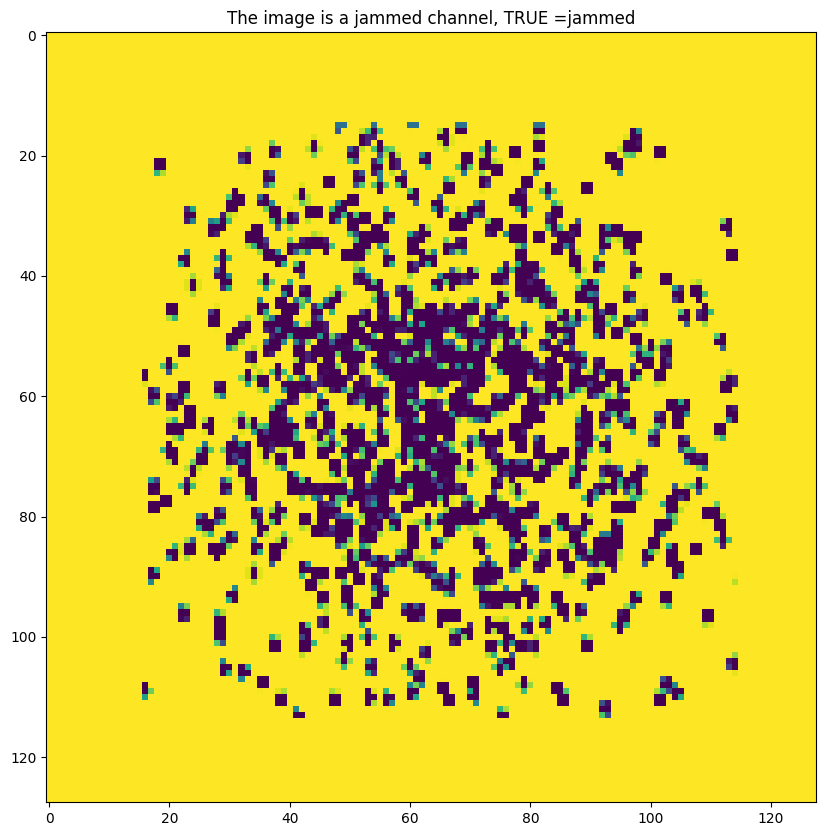

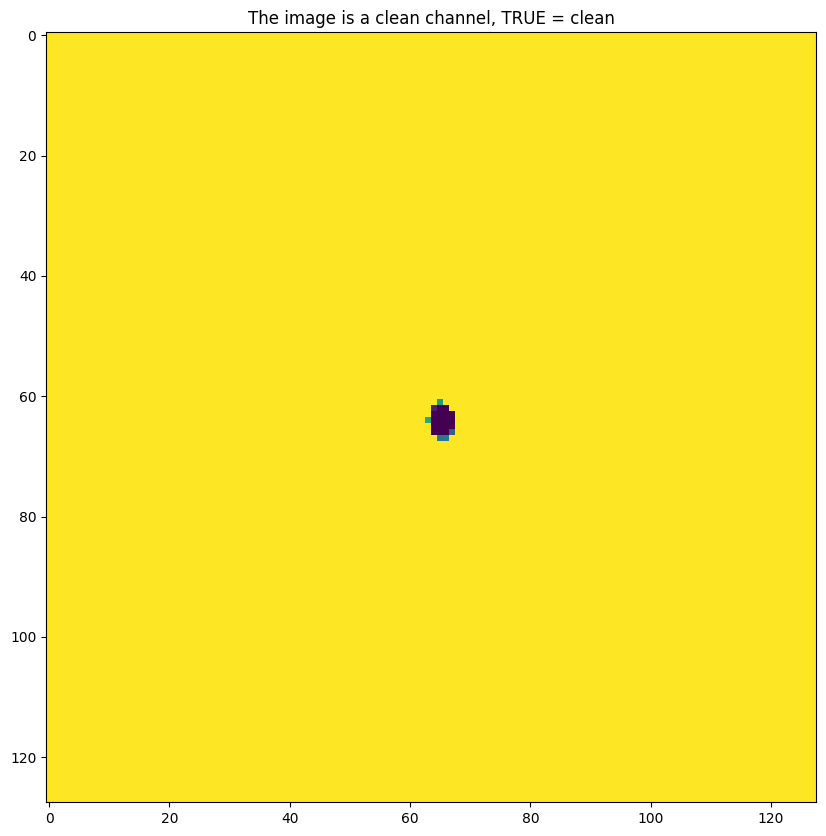

In [19]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [20]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [21]:
values_th=np.arange(min_range_th,max_range_th,0.0005) ## range btw the min of the recon error and the maximum above all samples in the validation set
print(len(values_th))

104


In [22]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0047


  0%|          | 2/800 [00:00<00:51, 15.36it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0527


  0%|          | 4/800 [00:00<00:52, 15.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0529


  1%|          | 6/800 [00:00<00:50, 15.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0165


  1%|          | 8/800 [00:00<00:49, 16.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


  1%|▏         | 10/800 [00:00<00:48, 16.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0192


  2%|▏         | 12/800 [00:00<00:47, 16.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0520


  2%|▏         | 14/800 [00:00<00:49, 15.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


  2%|▏         | 16/800 [00:01<00:49, 15.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0158


  2%|▏         | 18/800 [00:01<00:48, 15.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0046


  2%|▎         | 20/800 [00:01<00:50, 15.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0523


  3%|▎         | 22/800 [00:01<00:49, 15.65it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


  3%|▎         | 24/800 [00:01<00:50, 15.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0531


  3%|▎         | 26/800 [00:01<00:50, 15.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0532


  4%|▎         | 28/800 [00:01<00:51, 15.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0534


  4%|▍         | 30/800 [00:01<00:49, 15.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


  4%|▍         | 32/800 [00:02<00:48, 15.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0531


  4%|▍         | 34/800 [00:02<00:47, 16.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0532


  4%|▍         | 36/800 [00:02<00:48, 15.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0521


  5%|▍         | 38/800 [00:02<00:48, 15.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


  5%|▌         | 40/800 [00:02<00:49, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0045


  5%|▌         | 42/800 [00:02<00:48, 15.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0527


  6%|▌         | 44/800 [00:02<00:47, 15.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0044


  6%|▌         | 46/800 [00:02<00:49, 15.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0175


  6%|▌         | 48/800 [00:03<00:49, 15.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


  6%|▋         | 50/800 [00:03<00:50, 14.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0523


  6%|▋         | 52/800 [00:03<00:52, 14.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


  7%|▋         | 54/800 [00:03<00:51, 14.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


  7%|▋         | 56/800 [00:03<00:51, 14.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0530


  7%|▋         | 58/800 [00:03<00:48, 15.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0159


  8%|▊         | 60/800 [00:03<00:47, 15.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0537


  8%|▊         | 62/800 [00:03<00:46, 15.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0529


  8%|▊         | 64/800 [00:04<00:45, 16.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0521


  8%|▊         | 66/800 [00:04<00:45, 16.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0538


  8%|▊         | 68/800 [00:04<00:46, 15.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


  9%|▉         | 70/800 [00:04<00:46, 15.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0169


  9%|▉         | 72/800 [00:04<00:47, 15.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0190


  9%|▉         | 74/800 [00:04<00:47, 15.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0163


 10%|▉         | 76/800 [00:04<00:46, 15.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 10%|▉         | 78/800 [00:05<00:46, 15.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 10%|█         | 80/800 [00:05<00:46, 15.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0039


 10%|█         | 82/800 [00:05<00:45, 15.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0173


 10%|█         | 84/800 [00:05<00:47, 15.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0152


 11%|█         | 86/800 [00:05<00:47, 15.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 11%|█         | 88/800 [00:05<00:49, 14.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 11%|█▏        | 90/800 [00:05<00:50, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0044


 12%|█▏        | 92/800 [00:05<00:50, 14.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0556


 12%|█▏        | 94/800 [00:06<00:48, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0534


 12%|█▏        | 96/800 [00:06<00:46, 15.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0527


 12%|█▏        | 98/800 [00:06<00:46, 15.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0044


 12%|█▎        | 100/800 [00:06<00:46, 15.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0165


 13%|█▎        | 102/800 [00:06<00:45, 15.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 13%|█▎        | 104/800 [00:06<00:44, 15.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0541


 13%|█▎        | 106/800 [00:06<00:46, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0539


 14%|█▎        | 108/800 [00:07<00:45, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 14%|█▍        | 110/800 [00:07<00:44, 15.64it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0044


 14%|█▍        | 112/800 [00:07<00:44, 15.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0526


 14%|█▍        | 114/800 [00:07<00:45, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 14%|█▍        | 116/800 [00:07<00:45, 15.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0046


 15%|█▍        | 118/800 [00:07<00:45, 15.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0040


 15%|█▌        | 120/800 [00:07<00:45, 14.96it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0543


 15%|█▌        | 122/800 [00:07<00:48, 13.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 16%|█▌        | 124/800 [00:08<00:51, 13.22it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0535


 16%|█▌        | 126/800 [00:08<00:52, 12.75it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0533


 16%|█▌        | 128/800 [00:08<00:55, 12.21it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 16%|█▋        | 130/800 [00:08<00:54, 12.29it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0519


 16%|█▋        | 132/800 [00:08<00:54, 12.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0537


 17%|█▋        | 134/800 [00:08<00:53, 12.34it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0156


 17%|█▋        | 136/800 [00:09<00:56, 11.75it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0134


 17%|█▋        | 138/800 [00:09<00:56, 11.78it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0169


 18%|█▊        | 140/800 [00:09<00:56, 11.63it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0467


 18%|█▊        | 142/800 [00:09<00:58, 11.31it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0040


 18%|█▊        | 144/800 [00:09<00:59, 11.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0533


 18%|█▊        | 146/800 [00:10<00:58, 11.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0152


 18%|█▊        | 148/800 [00:10<00:56, 11.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0157


 19%|█▉        | 150/800 [00:10<00:54, 11.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0545


 19%|█▉        | 152/800 [00:10<00:51, 12.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0529


 19%|█▉        | 154/800 [00:10<00:49, 12.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0530


 20%|█▉        | 156/800 [00:10<00:46, 13.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0522


 20%|█▉        | 158/800 [00:10<00:44, 14.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0159


 20%|██        | 160/800 [00:11<00:44, 14.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0528


 20%|██        | 162/800 [00:11<00:42, 15.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0540


 20%|██        | 164/800 [00:11<00:41, 15.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 21%|██        | 166/800 [00:11<00:41, 15.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0463


 21%|██        | 168/800 [00:11<00:41, 15.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 21%|██▏       | 170/800 [00:11<00:40, 15.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0530


 22%|██▏       | 172/800 [00:11<00:41, 15.16it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0039


 22%|██▏       | 174/800 [00:11<00:40, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0534


 22%|██▏       | 176/800 [00:12<00:39, 15.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0160


 22%|██▏       | 178/800 [00:12<00:39, 15.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0522


 22%|██▎       | 180/800 [00:12<00:40, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0536


 23%|██▎       | 182/800 [00:12<00:39, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 23%|██▎       | 184/800 [00:12<00:41, 14.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 23%|██▎       | 186/800 [00:12<00:41, 14.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0547


 24%|██▎       | 188/800 [00:12<00:41, 14.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0535


 24%|██▍       | 190/800 [00:13<00:41, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0533


 24%|██▍       | 192/800 [00:13<00:41, 14.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0535


 24%|██▍       | 194/800 [00:13<00:42, 14.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0515


 24%|██▍       | 196/800 [00:13<00:42, 14.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0172


 25%|██▍       | 198/800 [00:13<00:41, 14.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0527


 25%|██▌       | 200/800 [00:13<00:40, 14.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0524


 25%|██▌       | 202/800 [00:13<00:40, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0540


 26%|██▌       | 204/800 [00:13<00:39, 15.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0529


 26%|██▌       | 206/800 [00:14<00:39, 15.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0529


 26%|██▌       | 208/800 [00:14<00:38, 15.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0537


 26%|██▋       | 210/800 [00:14<00:38, 15.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 26%|██▋       | 212/800 [00:14<00:37, 15.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0046


 27%|██▋       | 214/800 [00:14<00:38, 15.05it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0474


 27%|██▋       | 216/800 [00:14<00:39, 14.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 27%|██▋       | 218/800 [00:14<00:39, 14.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 28%|██▊       | 220/800 [00:15<00:39, 14.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 28%|██▊       | 222/800 [00:15<00:40, 14.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0542


 28%|██▊       | 224/800 [00:15<00:40, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0147


 28%|██▊       | 226/800 [00:15<00:39, 14.39it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0039


 28%|██▊       | 228/800 [00:15<00:39, 14.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0526


 29%|██▉       | 230/800 [00:15<00:38, 14.62it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0530


 29%|██▉       | 232/800 [00:15<00:39, 14.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 29%|██▉       | 234/800 [00:16<00:37, 15.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0447


 30%|██▉       | 236/800 [00:16<00:36, 15.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0530


 30%|██▉       | 238/800 [00:16<00:36, 15.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0543


 30%|███       | 240/800 [00:16<00:36, 15.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0158


 30%|███       | 242/800 [00:16<00:37, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0540


 30%|███       | 244/800 [00:16<00:37, 14.72it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0525


 31%|███       | 246/800 [00:16<00:38, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0525


 31%|███       | 248/800 [00:16<00:38, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0533


 31%|███▏      | 250/800 [00:17<00:37, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0535


 32%|███▏      | 252/800 [00:17<00:37, 14.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0171


 32%|███▏      | 254/800 [00:17<00:36, 14.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0529


 32%|███▏      | 256/800 [00:17<00:36, 15.06it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0527


 32%|███▏      | 258/800 [00:17<00:37, 14.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 32%|███▎      | 260/800 [00:17<00:36, 14.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 33%|███▎      | 262/800 [00:17<00:35, 15.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 33%|███▎      | 264/800 [00:18<00:37, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 33%|███▎      | 266/800 [00:18<00:36, 14.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0464


 34%|███▎      | 268/800 [00:18<00:35, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0044


 34%|███▍      | 270/800 [00:18<00:34, 15.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 34%|███▍      | 272/800 [00:18<00:35, 14.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 34%|███▍      | 274/800 [00:18<00:36, 14.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0521


 34%|███▍      | 276/800 [00:18<00:35, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0046


 35%|███▍      | 278/800 [00:18<00:35, 14.91it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0045


 35%|███▌      | 280/800 [00:19<00:41, 12.40it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0534


 35%|███▌      | 282/800 [00:19<00:44, 11.56it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0155


 36%|███▌      | 284/800 [00:19<00:47, 10.80it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0533


 36%|███▌      | 286/800 [00:19<00:49, 10.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0171


 36%|███▌      | 288/800 [00:20<00:53,  9.51it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0539


 36%|███▌      | 289/800 [00:20<00:56,  8.99it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0172


 36%|███▋      | 290/800 [00:20<00:56,  9.00it/s]

1/1 [==============================] - 0s 86ms/step - loss: 0.0546


 36%|███▋      | 291/800 [00:20<01:05,  7.73it/s]

1/1 [==============================] - 0s 101ms/step - loss: 0.0039


 36%|███▋      | 292/800 [00:20<01:23,  6.07it/s]

1/1 [==============================] - 0s 65ms/step - loss: 0.0039


 37%|███▋      | 293/800 [00:21<01:29,  5.67it/s]

1/1 [==============================] - 0s 104ms/step - loss: 0.0529


 37%|███▋      | 294/800 [00:21<01:30,  5.58it/s]

1/1 [==============================] - 0s 59ms/step - loss: 0.0039


 37%|███▋      | 295/800 [00:21<01:32,  5.44it/s]

1/1 [==============================] - 0s 74ms/step - loss: 0.0532


 37%|███▋      | 296/800 [00:21<01:36,  5.20it/s]

1/1 [==============================] - 0s 71ms/step - loss: 0.0045


 37%|███▋      | 297/800 [00:21<01:35,  5.29it/s]

1/1 [==============================] - 0s 97ms/step - loss: 0.0140


 37%|███▋      | 298/800 [00:21<01:35,  5.25it/s]

1/1 [==============================] - 0s 66ms/step - loss: 0.0543


 37%|███▋      | 299/800 [00:22<01:38,  5.07it/s]

1/1 [==============================] - 0s 92ms/step - loss: 0.0039


 38%|███▊      | 300/800 [00:22<01:46,  4.68it/s]

1/1 [==============================] - 0s 77ms/step - loss: 0.0046


 38%|███▊      | 301/800 [00:22<01:50,  4.50it/s]

1/1 [==============================] - 0s 76ms/step - loss: 0.0163


 38%|███▊      | 302/800 [00:22<01:47,  4.63it/s]

1/1 [==============================] - 0s 118ms/step - loss: 0.0544


 38%|███▊      | 303/800 [00:23<02:06,  3.93it/s]

1/1 [==============================] - 0s 63ms/step - loss: 0.0538


 38%|███▊      | 304/800 [00:23<02:05,  3.97it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0450


 38%|███▊      | 305/800 [00:23<01:46,  4.63it/s]

1/1 [==============================] - 0s 69ms/step - loss: 0.0046


 38%|███▊      | 306/800 [00:23<01:37,  5.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0532


 38%|███▊      | 307/800 [00:23<01:25,  5.73it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0171


 39%|███▊      | 309/800 [00:24<01:10,  6.98it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0190


 39%|███▉      | 311/800 [00:24<01:01,  7.99it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0527


 39%|███▉      | 312/800 [00:24<01:03,  7.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0522


 39%|███▉      | 314/800 [00:24<00:55,  8.76it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0531


 40%|███▉      | 316/800 [00:24<00:51,  9.48it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0531


 40%|███▉      | 317/800 [00:24<00:55,  8.74it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0040


 40%|███▉      | 318/800 [00:25<00:54,  8.84it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0531


 40%|███▉      | 319/800 [00:25<00:58,  8.21it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0169


 40%|████      | 320/800 [00:25<00:57,  8.33it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0548


 40%|████      | 321/800 [00:25<00:56,  8.53it/s]

1/1 [==============================] - 0s 82ms/step - loss: 0.0532


 40%|████      | 322/800 [00:25<01:08,  6.97it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0150


 40%|████      | 323/800 [00:25<01:04,  7.42it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0537


 40%|████      | 324/800 [00:25<01:05,  7.29it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0039


 41%|████      | 325/800 [00:26<01:12,  6.59it/s]

1/1 [==============================] - 0s 57ms/step - loss: 0.0536


 41%|████      | 326/800 [00:26<01:10,  6.77it/s]

1/1 [==============================] - 0s 66ms/step - loss: 0.0039


 41%|████      | 327/800 [00:26<01:09,  6.77it/s]

1/1 [==============================] - 0s 112ms/step - loss: 0.0534


 41%|████      | 328/800 [00:26<01:16,  6.17it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0150


 41%|████      | 329/800 [00:26<01:16,  6.15it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0178


 41%|████▏     | 330/800 [00:26<01:08,  6.89it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0525


 41%|████▏     | 331/800 [00:26<01:02,  7.54it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0187


 42%|████▏     | 332/800 [00:27<01:01,  7.65it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0039


 42%|████▏     | 333/800 [00:27<00:57,  8.14it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0547


 42%|████▏     | 335/800 [00:27<00:53,  8.77it/s]

1/1 [==============================] - 0s 62ms/step - loss: 0.0040


 42%|████▏     | 336/800 [00:27<00:53,  8.66it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0534


 42%|████▏     | 337/800 [00:27<00:52,  8.78it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0040


 42%|████▏     | 338/800 [00:27<00:56,  8.12it/s]

1/1 [==============================] - 0s 66ms/step - loss: 0.0039


 42%|████▏     | 339/800 [00:27<00:57,  8.01it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0535


 42%|████▎     | 340/800 [00:28<00:56,  8.15it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0533


 43%|████▎     | 341/800 [00:28<00:56,  8.14it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0046


 43%|████▎     | 342/800 [00:28<01:02,  7.32it/s]

1/1 [==============================] - 0s 64ms/step - loss: 0.0537


 43%|████▎     | 343/800 [00:28<01:05,  6.95it/s]

1/1 [==============================] - 0s 85ms/step - loss: 0.0527


 43%|████▎     | 344/800 [00:28<01:13,  6.22it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0523


 43%|████▎     | 345/800 [00:28<01:09,  6.53it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0040


 43%|████▎     | 347/800 [00:29<01:01,  7.42it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0045


 44%|████▎     | 348/800 [00:29<00:57,  7.82it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0039


 44%|████▎     | 349/800 [00:29<00:57,  7.81it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0173


 44%|████▍     | 350/800 [00:29<01:00,  7.39it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0535


 44%|████▍     | 351/800 [00:29<01:05,  6.84it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0046


 44%|████▍     | 352/800 [00:29<01:03,  7.10it/s]

1/1 [==============================] - 0s 64ms/step - loss: 0.0537


 44%|████▍     | 353/800 [00:29<01:04,  6.93it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0536


 44%|████▍     | 354/800 [00:30<01:03,  7.06it/s]

1/1 [==============================] - 0s 59ms/step - loss: 0.0519


 44%|████▍     | 355/800 [00:30<01:17,  5.76it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0509


 44%|████▍     | 356/800 [00:30<01:10,  6.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 45%|████▍     | 357/800 [00:30<01:03,  6.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 45%|████▍     | 359/800 [00:30<00:47,  9.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 45%|████▌     | 361/800 [00:30<00:40, 10.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0463


 45%|████▌     | 363/800 [00:30<00:36, 11.91it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0158


 46%|████▌     | 365/800 [00:31<00:35, 12.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0520


 46%|████▌     | 367/800 [00:31<00:33, 12.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0162


 46%|████▌     | 369/800 [00:31<00:32, 13.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0533


 46%|████▋     | 371/800 [00:31<00:31, 13.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0535


 47%|████▋     | 373/800 [00:31<00:31, 13.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 47%|████▋     | 375/800 [00:31<00:30, 13.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0443


 47%|████▋     | 377/800 [00:31<00:29, 14.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0045


 47%|████▋     | 379/800 [00:32<00:29, 14.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0040


 48%|████▊     | 381/800 [00:32<00:29, 14.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0532


 48%|████▊     | 383/800 [00:32<00:29, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0543


 48%|████▊     | 385/800 [00:32<00:29, 14.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 48%|████▊     | 387/800 [00:32<00:29, 14.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0550


 49%|████▊     | 389/800 [00:32<00:29, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0539


 49%|████▉     | 391/800 [00:32<00:28, 14.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0039


 49%|████▉     | 393/800 [00:33<00:28, 14.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0040


 49%|████▉     | 395/800 [00:33<00:28, 14.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0152


 50%|████▉     | 397/800 [00:33<00:29, 13.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0170


 50%|████▉     | 399/800 [00:33<00:29, 13.44it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0528


 50%|█████     | 401/800 [00:33<00:30, 12.97it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0529


 50%|█████     | 403/800 [00:33<00:32, 12.20it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0039


 51%|█████     | 405/800 [00:34<00:35, 11.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0528


 51%|█████     | 407/800 [00:34<00:35, 11.13it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 51%|█████     | 409/800 [00:34<00:33, 11.72it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0039


 51%|█████▏    | 411/800 [00:34<00:34, 11.41it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0526


 52%|█████▏    | 413/800 [00:34<00:35, 11.04it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0530


 52%|█████▏    | 415/800 [00:34<00:35, 10.86it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0039


 52%|█████▏    | 417/800 [00:35<00:35, 10.77it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0522


 52%|█████▏    | 419/800 [00:35<00:35, 10.63it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0039


 53%|█████▎    | 421/800 [00:35<00:36, 10.49it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0529


 53%|█████▎    | 423/800 [00:35<00:34, 10.88it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0039


 53%|█████▎    | 425/800 [00:35<00:35, 10.59it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0044


 53%|█████▎    | 427/800 [00:36<00:33, 10.98it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0160


 54%|█████▎    | 429/800 [00:36<00:34, 10.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0532


 54%|█████▍    | 431/800 [00:36<00:31, 11.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0039


 54%|█████▍    | 433/800 [00:36<00:29, 12.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0525


 54%|█████▍    | 435/800 [00:36<00:29, 12.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0541


 55%|█████▍    | 437/800 [00:36<00:28, 12.94it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0533


 55%|█████▍    | 439/800 [00:36<00:27, 13.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0133


 55%|█████▌    | 441/800 [00:37<00:26, 13.62it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0175


 55%|█████▌    | 443/800 [00:37<00:25, 14.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0521


 56%|█████▌    | 445/800 [00:37<00:24, 14.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0040


 56%|█████▌    | 447/800 [00:37<00:25, 14.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0541


 56%|█████▌    | 449/800 [00:37<00:24, 14.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0529


 56%|█████▋    | 451/800 [00:37<00:24, 14.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0172


 57%|█████▋    | 453/800 [00:37<00:23, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0547


 57%|█████▋    | 455/800 [00:38<00:23, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0531


 57%|█████▋    | 457/800 [00:38<00:24, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


 57%|█████▋    | 459/800 [00:38<00:24, 14.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0178


 58%|█████▊    | 461/800 [00:38<00:24, 14.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 58%|█████▊    | 463/800 [00:38<00:23, 14.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0510


 58%|█████▊    | 465/800 [00:38<00:23, 14.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0534


 58%|█████▊    | 467/800 [00:38<00:23, 14.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 59%|█████▊    | 469/800 [00:39<00:23, 14.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 59%|█████▉    | 471/800 [00:39<00:23, 14.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0540


 59%|█████▉    | 473/800 [00:39<00:22, 14.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0541


 59%|█████▉    | 475/800 [00:39<00:22, 14.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0165


 60%|█████▉    | 477/800 [00:39<00:22, 14.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 60%|█████▉    | 479/800 [00:39<00:22, 14.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0538


 60%|██████    | 481/800 [00:39<00:22, 14.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0454


 60%|██████    | 483/800 [00:40<00:22, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0045


 61%|██████    | 485/800 [00:40<00:22, 14.12it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 61%|██████    | 487/800 [00:40<00:22, 14.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0178


 61%|██████    | 489/800 [00:40<00:22, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0533


 61%|██████▏   | 491/800 [00:40<00:22, 13.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0174


 62%|██████▏   | 493/800 [00:40<00:21, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0454


 62%|██████▏   | 495/800 [00:40<00:21, 14.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0537


 62%|██████▏   | 497/800 [00:41<00:21, 14.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0541


 62%|██████▏   | 499/800 [00:41<00:20, 14.56it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0039


 63%|██████▎   | 501/800 [00:41<00:20, 14.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 63%|██████▎   | 503/800 [00:41<00:20, 14.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 63%|██████▎   | 505/800 [00:41<00:20, 14.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0536


 63%|██████▎   | 507/800 [00:41<00:20, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 64%|██████▎   | 509/800 [00:41<00:21, 13.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 64%|██████▍   | 511/800 [00:42<00:20, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0040


 64%|██████▍   | 513/800 [00:42<00:20, 13.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0159


 64%|██████▍   | 515/800 [00:42<00:20, 14.07it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0538


 65%|██████▍   | 517/800 [00:42<00:33,  8.45it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0045


 65%|██████▍   | 519/800 [00:42<00:29,  9.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0526


 65%|██████▌   | 521/800 [00:43<00:27, 10.11it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0178


 65%|██████▌   | 523/800 [00:43<00:25, 10.67it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0534


 66%|██████▌   | 525/800 [00:43<00:25, 10.77it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0155


 66%|██████▌   | 527/800 [00:43<00:24, 11.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0039


 66%|██████▌   | 529/800 [00:43<00:23, 11.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0039


 66%|██████▋   | 531/800 [00:43<00:22, 11.76it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0167


 67%|██████▋   | 533/800 [00:44<00:22, 11.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0045


 67%|██████▋   | 535/800 [00:44<00:21, 12.16it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0039


 67%|██████▋   | 537/800 [00:44<00:20, 12.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0515


 67%|██████▋   | 539/800 [00:44<00:20, 12.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 68%|██████▊   | 541/800 [00:44<00:20, 12.81it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0039


 68%|██████▊   | 543/800 [00:44<00:19, 12.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0157


 68%|██████▊   | 545/800 [00:44<00:19, 12.86it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0531


 68%|██████▊   | 547/800 [00:45<00:19, 12.78it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0039


 69%|██████▊   | 549/800 [00:45<00:19, 12.82it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0511


 69%|██████▉   | 551/800 [00:45<00:20, 12.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0159


 69%|██████▉   | 553/800 [00:45<00:20, 12.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0523


 69%|██████▉   | 555/800 [00:45<00:19, 12.73it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0538


 70%|██████▉   | 557/800 [00:45<00:18, 12.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0145


 70%|██████▉   | 559/800 [00:46<00:18, 12.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0528


 70%|███████   | 561/800 [00:46<00:18, 13.03it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0517


 70%|███████   | 563/800 [00:46<00:20, 11.76it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0525


 71%|███████   | 565/800 [00:46<00:20, 11.22it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0532


 71%|███████   | 567/800 [00:46<00:21, 10.67it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0550


 71%|███████   | 569/800 [00:47<00:21, 10.64it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0039


 71%|███████▏  | 571/800 [00:47<00:21, 10.58it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0477


 72%|███████▏  | 573/800 [00:47<00:22, 10.26it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0156


 72%|███████▏  | 575/800 [00:47<00:22, 10.13it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0461


 72%|███████▏  | 577/800 [00:47<00:21, 10.49it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0529


 72%|███████▏  | 579/800 [00:48<00:21, 10.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0181


 73%|███████▎  | 581/800 [00:48<00:20, 10.59it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0192


 73%|███████▎  | 583/800 [00:48<00:20, 10.38it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0040


 73%|███████▎  | 585/800 [00:48<00:20, 10.50it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0535


 73%|███████▎  | 587/800 [00:48<00:20, 10.56it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0531


 74%|███████▎  | 589/800 [00:48<00:20, 10.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0526


 74%|███████▍  | 591/800 [00:49<00:18, 11.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0045


 74%|███████▍  | 593/800 [00:49<00:17, 12.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0039


 74%|███████▍  | 595/800 [00:49<00:16, 12.64it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0536


 75%|███████▍  | 597/800 [00:49<00:15, 12.73it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0039


 75%|███████▍  | 599/800 [00:49<00:15, 13.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0044


 75%|███████▌  | 601/800 [00:49<00:14, 13.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 75%|███████▌  | 603/800 [00:49<00:14, 13.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0454


 76%|███████▌  | 605/800 [00:50<00:13, 14.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0537


 76%|███████▌  | 607/800 [00:50<00:13, 13.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 76%|███████▌  | 609/800 [00:50<00:13, 14.14it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0044


 76%|███████▋  | 611/800 [00:50<00:13, 14.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0529


 77%|███████▋  | 613/800 [00:50<00:13, 13.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0537


 77%|███████▋  | 615/800 [00:50<00:13, 14.17it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0039


 77%|███████▋  | 617/800 [00:50<00:12, 14.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0528


 77%|███████▋  | 619/800 [00:51<00:12, 14.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0444


 78%|███████▊  | 621/800 [00:51<00:12, 13.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0046


 78%|███████▊  | 623/800 [00:51<00:12, 13.85it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0193


 78%|███████▊  | 625/800 [00:51<00:12, 13.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 78%|███████▊  | 627/800 [00:51<00:12, 13.39it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0525


 79%|███████▊  | 629/800 [00:51<00:12, 13.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0524


 79%|███████▉  | 631/800 [00:51<00:12, 13.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 79%|███████▉  | 633/800 [00:52<00:12, 13.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0532


 79%|███████▉  | 635/800 [00:52<00:11, 14.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0462


 80%|███████▉  | 637/800 [00:52<00:11, 14.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0533


 80%|███████▉  | 639/800 [00:52<00:11, 14.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0529


 80%|████████  | 641/800 [00:52<00:10, 14.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 80%|████████  | 643/800 [00:52<00:10, 14.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0162


 81%|████████  | 645/800 [00:52<00:10, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0528


 81%|████████  | 647/800 [00:53<00:10, 14.41it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0159


 81%|████████  | 649/800 [00:53<00:11, 13.20it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0547


 81%|████████▏ | 651/800 [00:53<00:11, 13.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0165


 82%|████████▏ | 653/800 [00:53<00:10, 13.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0539


 82%|████████▏ | 655/800 [00:53<00:10, 13.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0039


 82%|████████▏ | 657/800 [00:53<00:10, 13.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0045


 82%|████████▏ | 659/800 [00:53<00:10, 13.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0536


 83%|████████▎ | 661/800 [00:54<00:09, 13.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 83%|████████▎ | 663/800 [00:54<00:09, 13.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0189


 83%|████████▎ | 665/800 [00:54<00:09, 14.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0534


 83%|████████▎ | 667/800 [00:54<00:09, 14.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 84%|████████▎ | 669/800 [00:54<00:09, 13.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0538


 84%|████████▍ | 671/800 [00:54<00:09, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 84%|████████▍ | 673/800 [00:54<00:09, 14.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0537


 84%|████████▍ | 675/800 [00:55<00:09, 13.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0541


 85%|████████▍ | 677/800 [00:55<00:08, 13.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0170


 85%|████████▍ | 679/800 [00:55<00:08, 13.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 85%|████████▌ | 681/800 [00:55<00:08, 14.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 85%|████████▌ | 683/800 [00:55<00:08, 13.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0530


 86%|████████▌ | 685/800 [00:55<00:08, 14.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0045


 86%|████████▌ | 687/800 [00:55<00:07, 14.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0539


 86%|████████▌ | 689/800 [00:56<00:07, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0538


 86%|████████▋ | 691/800 [00:56<00:07, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0529


 87%|████████▋ | 693/800 [00:56<00:07, 14.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0460


 87%|████████▋ | 695/800 [00:56<00:07, 14.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0537


 87%|████████▋ | 697/800 [00:56<00:07, 14.36it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0526


 87%|████████▋ | 699/800 [00:56<00:06, 14.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0520


 88%|████████▊ | 701/800 [00:56<00:06, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0510


 88%|████████▊ | 703/800 [00:57<00:06, 14.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0541


 88%|████████▊ | 705/800 [00:57<00:06, 13.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 88%|████████▊ | 707/800 [00:57<00:06, 13.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0538


 89%|████████▊ | 709/800 [00:57<00:06, 13.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0539


 89%|████████▉ | 711/800 [00:57<00:06, 13.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0526


 89%|████████▉ | 713/800 [00:57<00:06, 13.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0550


 89%|████████▉ | 715/800 [00:57<00:06, 14.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0167


 90%|████████▉ | 717/800 [00:58<00:05, 14.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0521


 90%|████████▉ | 719/800 [00:58<00:05, 14.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 90%|█████████ | 721/800 [00:58<00:05, 14.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0045


 90%|█████████ | 723/800 [00:58<00:05, 14.33it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0532


 91%|█████████ | 725/800 [00:58<00:05, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0534


 91%|█████████ | 727/800 [00:58<00:05, 14.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0539


 91%|█████████ | 729/800 [00:58<00:04, 14.48it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0525


 91%|█████████▏| 731/800 [00:59<00:05, 13.01it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0039


 92%|█████████▏| 733/800 [00:59<00:05, 12.33it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0525


 92%|█████████▏| 735/800 [00:59<00:06, 10.73it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0523


 92%|█████████▏| 737/800 [00:59<00:06, 10.19it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0540


 92%|█████████▏| 739/800 [00:59<00:06, 10.05it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0522


 93%|█████████▎| 741/800 [01:00<00:05, 10.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0531


 93%|█████████▎| 743/800 [01:00<00:05, 10.76it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0551


 93%|█████████▎| 745/800 [01:00<00:05, 10.39it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0527


 93%|█████████▎| 747/800 [01:00<00:04, 10.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0530


 94%|█████████▎| 749/800 [01:00<00:04, 10.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0530


 94%|█████████▍| 751/800 [01:01<00:04, 10.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0524


 94%|█████████▍| 753/800 [01:01<00:04, 11.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0526


 94%|█████████▍| 755/800 [01:01<00:03, 11.46it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0540


 95%|█████████▍| 757/800 [01:01<00:03, 11.32it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0176


 95%|█████████▍| 759/800 [01:01<00:03, 11.21it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0530


 95%|█████████▌| 761/800 [01:01<00:03, 10.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0045


 95%|█████████▌| 763/800 [01:02<00:03, 11.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0516


 96%|█████████▌| 765/800 [01:02<00:02, 12.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0175


 96%|█████████▌| 767/800 [01:02<00:02, 12.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0543


 96%|█████████▌| 769/800 [01:02<00:02, 13.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0046


 96%|█████████▋| 771/800 [01:02<00:02, 13.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 97%|█████████▋| 773/800 [01:02<00:01, 13.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0549


 97%|█████████▋| 775/800 [01:02<00:01, 13.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0045


 97%|█████████▋| 777/800 [01:03<00:01, 13.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0553


 97%|█████████▋| 779/800 [01:03<00:01, 13.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0529


 98%|█████████▊| 781/800 [01:03<00:01, 13.62it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0530


 98%|█████████▊| 783/800 [01:03<00:01, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0531


 98%|█████████▊| 785/800 [01:03<00:01, 13.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 98%|█████████▊| 787/800 [01:03<00:00, 13.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0045


 99%|█████████▊| 789/800 [01:04<00:00, 13.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0174


 99%|█████████▉| 791/800 [01:04<00:00, 13.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0526


 99%|█████████▉| 793/800 [01:04<00:00, 13.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0187


 99%|█████████▉| 795/800 [01:04<00:00, 13.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0046


100%|█████████▉| 797/800 [01:04<00:00, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0161


100%|█████████▉| 799/800 [01:04<00:00, 13.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0039


100%|██████████| 800/800 [01:04<00:00, 12.34it/s]

800


In [23]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [24]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [25]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025, 0.00625, 0.01125, 0.01625, 0.02625, 0.03, 0.03125, 0.03375, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.04375, 0.05, 0.0925, 0.18375, 0.3075, 0.40875, 0.46625, 0.48875, 0.49875]
[0.5, 0.335, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2475, 0.245, 0.2425, 0.2375, 0.22625, 0.1975, 0.17125, 0.15375, 0.13375, 0.10125, 0.0575, 0.01875, 0.00625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

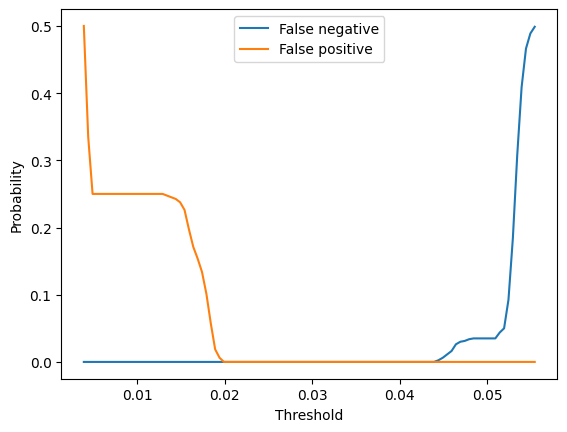

In [26]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [27]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0047


  0%|          | 2/800 [00:00<00:53, 14.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0527


  0%|          | 4/800 [00:00<00:51, 15.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0529


  1%|          | 6/800 [00:00<00:51, 15.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0165


  1%|          | 8/800 [00:00<00:52, 14.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


  1%|▏         | 10/800 [00:00<00:51, 15.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0192


  2%|▏         | 12/800 [00:00<00:53, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0520


  2%|▏         | 14/800 [00:00<00:53, 14.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


  2%|▏         | 16/800 [00:01<00:53, 14.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0158


  2%|▏         | 18/800 [00:01<00:51, 15.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0046


  2%|▎         | 20/800 [00:01<00:52, 14.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0523


  3%|▎         | 22/800 [00:01<00:51, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


  3%|▎         | 24/800 [00:01<00:50, 15.41it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0531


  3%|▎         | 26/800 [00:01<00:51, 15.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0532


  4%|▎         | 28/800 [00:01<00:50, 15.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0534


  4%|▍         | 30/800 [00:01<00:51, 14.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


  4%|▍         | 32/800 [00:02<00:51, 14.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0531


  4%|▍         | 34/800 [00:02<00:52, 14.53it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0532


  4%|▍         | 36/800 [00:02<00:52, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0521


  5%|▍         | 38/800 [00:02<00:51, 14.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0039


  5%|▌         | 40/800 [00:02<00:52, 14.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0045


  5%|▌         | 42/800 [00:02<00:53, 14.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0527


  6%|▌         | 44/800 [00:02<00:51, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0044


  6%|▌         | 46/800 [00:03<00:49, 15.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0175


  6%|▌         | 48/800 [00:03<00:50, 14.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0039


  6%|▋         | 50/800 [00:03<00:49, 15.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0523


  6%|▋         | 52/800 [00:03<00:48, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0039


  7%|▋         | 54/800 [00:03<00:47, 15.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


  7%|▋         | 56/800 [00:03<00:47, 15.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0530


  7%|▋         | 58/800 [00:03<00:46, 15.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0159


  8%|▊         | 60/800 [00:03<00:49, 15.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0537


  8%|▊         | 62/800 [00:04<00:49, 14.97it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0529


  8%|▊         | 64/800 [00:04<00:48, 15.26it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0521


  8%|▊         | 66/800 [00:04<00:46, 15.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0538


  8%|▊         | 68/800 [00:04<00:49, 14.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


  9%|▉         | 70/800 [00:04<00:47, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0169


  9%|▉         | 72/800 [00:04<00:46, 15.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0190


  9%|▉         | 74/800 [00:04<00:47, 15.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0163


 10%|▉         | 76/800 [00:05<00:47, 15.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 10%|▉         | 78/800 [00:05<00:48, 14.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 10%|█         | 80/800 [00:05<00:47, 15.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 10%|█         | 82/800 [00:05<00:46, 15.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0173


 10%|█         | 84/800 [00:05<00:45, 15.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0152


 11%|█         | 86/800 [00:05<00:44, 15.96it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0039


 11%|█         | 88/800 [00:05<00:45, 15.79it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0039


 11%|█▏        | 90/800 [00:05<00:45, 15.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0044


 12%|█▏        | 92/800 [00:06<00:45, 15.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0556


 12%|█▏        | 94/800 [00:06<00:46, 15.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0534


 12%|█▏        | 96/800 [00:06<00:45, 15.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0527


 12%|█▏        | 98/800 [00:06<00:44, 15.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0044


 12%|█▎        | 100/800 [00:06<00:46, 15.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0165


 13%|█▎        | 102/800 [00:06<00:48, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 13%|█▎        | 104/800 [00:06<00:48, 14.21it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0541


 13%|█▎        | 106/800 [00:07<00:47, 14.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0539


 14%|█▎        | 108/800 [00:07<00:46, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 14%|█▍        | 110/800 [00:07<00:46, 14.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0044


 14%|█▍        | 112/800 [00:07<00:46, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0526


 14%|█▍        | 114/800 [00:07<00:44, 15.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 14%|█▍        | 116/800 [00:07<00:44, 15.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0046


 15%|█▍        | 118/800 [00:07<00:44, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0040


 15%|█▌        | 120/800 [00:07<00:45, 14.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0543


 15%|█▌        | 122/800 [00:08<00:45, 15.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 16%|█▌        | 124/800 [00:08<00:44, 15.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0535


 16%|█▌        | 126/800 [00:08<00:44, 15.12it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0533


 16%|█▌        | 128/800 [00:08<00:44, 15.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 16%|█▋        | 130/800 [00:08<00:44, 15.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0519


 16%|█▋        | 132/800 [00:08<00:44, 14.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0537


 17%|█▋        | 134/800 [00:08<00:44, 14.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0156


 17%|█▋        | 136/800 [00:09<00:45, 14.68it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0134


 17%|█▋        | 138/800 [00:09<00:49, 13.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0169


 18%|█▊        | 140/800 [00:09<00:53, 12.31it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0467


 18%|█▊        | 142/800 [00:09<01:01, 10.74it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0040


 18%|█▊        | 144/800 [00:09<01:01, 10.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0533


 18%|█▊        | 146/800 [00:10<01:02, 10.41it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0152


 18%|█▊        | 148/800 [00:10<01:01, 10.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0157


 19%|█▉        | 150/800 [00:10<01:00, 10.78it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0545


 19%|█▉        | 152/800 [00:10<00:59, 10.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0529


 19%|█▉        | 154/800 [00:10<00:58, 10.98it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0530


 20%|█▉        | 156/800 [00:10<00:59, 10.85it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0522


 20%|█▉        | 158/800 [00:11<00:59, 10.76it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0159


 20%|██        | 160/800 [00:11<00:58, 11.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0528


 20%|██        | 162/800 [00:11<00:56, 11.21it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0540


 20%|██        | 164/800 [00:11<00:55, 11.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 21%|██        | 166/800 [00:11<00:52, 11.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0463


 21%|██        | 168/800 [00:11<00:49, 12.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 21%|██▏       | 170/800 [00:12<00:47, 13.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0530


 22%|██▏       | 172/800 [00:12<00:47, 13.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0039


 22%|██▏       | 174/800 [00:12<00:44, 14.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0534


 22%|██▏       | 176/800 [00:12<00:44, 14.15it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0160


 22%|██▏       | 178/800 [00:12<00:43, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0522


 22%|██▎       | 180/800 [00:12<00:42, 14.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0536


 23%|██▎       | 182/800 [00:12<00:41, 14.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 23%|██▎       | 184/800 [00:12<00:40, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 23%|██▎       | 186/800 [00:13<00:39, 15.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0547


 24%|██▎       | 188/800 [00:13<00:39, 15.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0535


 24%|██▍       | 190/800 [00:13<00:39, 15.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0533


 24%|██▍       | 192/800 [00:13<00:39, 15.58it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0535


 24%|██▍       | 194/800 [00:13<00:39, 15.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0515


 24%|██▍       | 196/800 [00:13<00:39, 15.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0172


 25%|██▍       | 198/800 [00:13<00:39, 15.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0527


 25%|██▌       | 200/800 [00:14<00:38, 15.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0524


 25%|██▌       | 202/800 [00:14<00:38, 15.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0540


 26%|██▌       | 204/800 [00:14<00:39, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0529


 26%|██▌       | 206/800 [00:14<00:38, 15.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0529


 26%|██▌       | 208/800 [00:14<00:39, 15.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0537


 26%|██▋       | 210/800 [00:14<00:38, 15.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 26%|██▋       | 212/800 [00:14<00:37, 15.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0046


 27%|██▋       | 214/800 [00:14<00:38, 15.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0474


 27%|██▋       | 216/800 [00:15<00:39, 14.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 27%|██▋       | 218/800 [00:15<00:39, 14.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 28%|██▊       | 220/800 [00:15<00:38, 15.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 28%|██▊       | 222/800 [00:15<00:38, 15.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0542


 28%|██▊       | 224/800 [00:15<00:37, 15.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0147


 28%|██▊       | 226/800 [00:15<00:38, 14.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 28%|██▊       | 228/800 [00:15<00:38, 14.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0526


 29%|██▉       | 230/800 [00:15<00:37, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0530


 29%|██▉       | 232/800 [00:16<00:38, 14.78it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0187


 29%|██▉       | 234/800 [00:16<00:39, 14.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0447


 30%|██▉       | 236/800 [00:16<00:38, 14.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0530


 30%|██▉       | 238/800 [00:16<00:38, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0543


 30%|███       | 240/800 [00:16<00:39, 14.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0158


 30%|███       | 242/800 [00:16<00:39, 14.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0540


 30%|███       | 244/800 [00:16<00:37, 14.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0525


 31%|███       | 246/800 [00:17<00:36, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0525


 31%|███       | 248/800 [00:17<00:36, 15.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0533


 31%|███▏      | 250/800 [00:17<00:36, 15.09it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0535


 32%|███▏      | 252/800 [00:17<00:36, 15.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0171


 32%|███▏      | 254/800 [00:17<00:35, 15.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0529


 32%|███▏      | 256/800 [00:17<00:34, 15.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0527


 32%|███▏      | 258/800 [00:17<00:36, 15.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 32%|███▎      | 260/800 [00:18<00:36, 14.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 33%|███▎      | 262/800 [00:18<00:36, 14.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 33%|███▎      | 264/800 [00:18<00:36, 14.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 33%|███▎      | 266/800 [00:18<00:36, 14.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0464


 34%|███▎      | 268/800 [00:18<00:36, 14.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0044


 34%|███▍      | 270/800 [00:18<00:36, 14.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 34%|███▍      | 272/800 [00:18<00:35, 14.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 34%|███▍      | 274/800 [00:18<00:36, 14.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0521


 34%|███▍      | 276/800 [00:19<00:35, 14.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0046


 35%|███▍      | 278/800 [00:19<00:36, 14.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0045


 35%|███▌      | 280/800 [00:19<00:34, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0534


 35%|███▌      | 282/800 [00:19<00:34, 15.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0155


 36%|███▌      | 284/800 [00:19<00:34, 15.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0533


 36%|███▌      | 286/800 [00:19<00:33, 15.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0171


 36%|███▌      | 288/800 [00:19<00:33, 15.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0172


 36%|███▋      | 290/800 [00:20<00:33, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 36%|███▋      | 292/800 [00:20<00:34, 14.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0529


 37%|███▋      | 294/800 [00:20<00:33, 15.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0532


 37%|███▋      | 296/800 [00:20<00:33, 14.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0140


 37%|███▋      | 298/800 [00:20<00:33, 14.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 38%|███▊      | 300/800 [00:20<00:34, 14.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0163


 38%|███▊      | 302/800 [00:20<00:34, 14.55it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0538


 38%|███▊      | 304/800 [00:21<00:49,  9.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0046


 38%|███▊      | 306/800 [00:21<00:45, 10.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 38%|███▊      | 308/800 [00:21<00:41, 11.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0530


 39%|███▉      | 310/800 [00:21<00:39, 12.44it/s]

1/1 [==============================] - 0s 131ms/step - loss: 0.0527


 39%|███▉      | 312/800 [00:21<00:46, 10.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0522


 39%|███▉      | 314/800 [00:22<01:06,  7.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0531


 40%|███▉      | 316/800 [00:22<00:58,  8.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0040


 40%|███▉      | 318/800 [00:22<00:52,  9.16it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0169


 40%|████      | 320/800 [00:22<00:48,  9.84it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0532


 40%|████      | 322/800 [00:23<01:14,  6.40it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0537


 40%|████      | 324/800 [00:23<01:03,  7.45it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0536


 41%|████      | 326/800 [00:23<00:56,  8.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0534


 41%|████      | 328/800 [00:23<00:51,  9.16it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0178


 41%|████▏     | 330/800 [00:24<00:48,  9.68it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0187


 42%|████▏     | 332/800 [00:24<00:46, 10.03it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0527


 42%|████▏     | 334/800 [00:24<00:47,  9.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0040


 42%|████▏     | 336/800 [00:24<00:46, 10.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0040


 42%|████▏     | 338/800 [00:24<00:41, 11.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0535


 42%|████▎     | 340/800 [00:24<00:38, 11.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0046


 43%|████▎     | 342/800 [00:25<00:35, 12.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0527


 43%|████▎     | 344/800 [00:25<00:35, 12.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0544


 43%|████▎     | 346/800 [00:25<00:34, 13.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0045


 44%|████▎     | 348/800 [00:25<00:32, 13.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0173


 44%|████▍     | 350/800 [00:25<00:32, 14.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0046


 44%|████▍     | 352/800 [00:25<00:31, 14.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0536


 44%|████▍     | 354/800 [00:25<00:31, 14.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0509


 44%|████▍     | 356/800 [00:26<00:31, 14.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0535


 45%|████▍     | 358/800 [00:26<00:30, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0536


 45%|████▌     | 360/800 [00:26<00:31, 14.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 45%|████▌     | 362/800 [00:26<00:30, 14.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0172


 46%|████▌     | 364/800 [00:26<00:30, 14.52it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0531


 46%|████▌     | 366/800 [00:26<00:29, 14.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 46%|████▌     | 368/800 [00:26<00:30, 14.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0529


 46%|████▋     | 370/800 [00:27<00:29, 14.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 46%|████▋     | 372/800 [00:27<00:29, 14.69it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0157


 47%|████▋     | 374/800 [00:27<00:28, 14.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0538


 47%|████▋     | 376/800 [00:27<00:28, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0533


 47%|████▋     | 378/800 [00:27<00:28, 14.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0040


 48%|████▊     | 380/800 [00:27<00:28, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0530


 48%|████▊     | 382/800 [00:27<00:28, 14.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0528


 48%|████▊     | 384/800 [00:27<00:28, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0545


 48%|████▊     | 386/800 [00:28<00:27, 15.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 48%|████▊     | 388/800 [00:28<00:28, 14.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0538


 49%|████▉     | 390/800 [00:28<00:28, 14.38it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0046


 49%|████▉     | 392/800 [00:28<00:28, 14.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0542


 49%|████▉     | 394/800 [00:28<00:28, 14.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0046


 50%|████▉     | 396/800 [00:28<00:28, 14.21it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0039


 50%|████▉     | 398/800 [00:28<00:28, 14.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 50%|█████     | 400/800 [00:29<00:28, 14.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 50%|█████     | 402/800 [00:29<00:28, 14.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0545


 50%|█████     | 404/800 [00:29<00:28, 14.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0041


 51%|█████     | 406/800 [00:29<00:27, 14.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 51%|█████     | 408/800 [00:29<00:27, 14.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 51%|█████▏    | 410/800 [00:29<00:26, 14.90it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0181


 52%|█████▏    | 412/800 [00:29<00:26, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0540


 52%|█████▏    | 414/800 [00:30<00:25, 14.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0535


 52%|█████▏    | 416/800 [00:30<00:26, 14.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0541


 52%|█████▏    | 418/800 [00:30<00:25, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0529


 52%|█████▎    | 420/800 [00:30<00:25, 14.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0535


 53%|█████▎    | 422/800 [00:30<00:25, 14.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0523


 53%|█████▎    | 424/800 [00:30<00:25, 15.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0511


 53%|█████▎    | 426/800 [00:30<00:24, 15.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 54%|█████▎    | 428/800 [00:31<00:24, 15.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0536


 54%|█████▍    | 430/800 [00:31<00:24, 14.85it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0170


 54%|█████▍    | 432/800 [00:31<00:24, 14.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0460


 54%|█████▍    | 434/800 [00:31<00:24, 14.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0177


 55%|█████▍    | 436/800 [00:31<00:24, 14.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0547


 55%|█████▍    | 438/800 [00:31<00:24, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0040


 55%|█████▌    | 440/800 [00:31<00:24, 14.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 55%|█████▌    | 442/800 [00:31<00:23, 14.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0545


 56%|█████▌    | 444/800 [00:32<00:23, 15.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 56%|█████▌    | 446/800 [00:32<00:23, 14.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0155


 56%|█████▌    | 448/800 [00:32<00:26, 13.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 56%|█████▋    | 450/800 [00:32<00:25, 13.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0533


 56%|█████▋    | 452/800 [00:32<00:24, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0527


 57%|█████▋    | 454/800 [00:32<00:24, 14.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0528


 57%|█████▋    | 456/800 [00:32<00:24, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0519


 57%|█████▋    | 458/800 [00:33<00:24, 13.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 57%|█████▊    | 460/800 [00:33<00:23, 14.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0131


 58%|█████▊    | 462/800 [00:33<00:23, 14.61it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0153


 58%|█████▊    | 464/800 [00:33<00:23, 14.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0536


 58%|█████▊    | 466/800 [00:33<00:22, 14.83it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0150


 58%|█████▊    | 468/800 [00:33<00:22, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0543


 59%|█████▉    | 470/800 [00:33<00:22, 14.86it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0039


 59%|█████▉    | 472/800 [00:34<00:21, 15.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0039


 59%|█████▉    | 474/800 [00:34<00:22, 14.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0528


 60%|█████▉    | 476/800 [00:34<00:22, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 60%|█████▉    | 478/800 [00:34<00:22, 14.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 60%|██████    | 480/800 [00:34<00:22, 14.53it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0527


 60%|██████    | 482/800 [00:34<00:24, 13.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0046


 60%|██████    | 484/800 [00:34<00:24, 12.84it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0039


 61%|██████    | 486/800 [00:35<00:27, 11.40it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0542


 61%|██████    | 488/800 [00:35<00:28, 11.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0162


 61%|██████▏   | 490/800 [00:35<00:29, 10.59it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0531


 62%|██████▏   | 492/800 [00:35<00:28, 10.99it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0459


 62%|██████▏   | 494/800 [00:35<00:27, 11.19it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0538


 62%|██████▏   | 496/800 [00:36<00:27, 11.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0046


 62%|██████▏   | 498/800 [00:36<00:27, 10.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0539


 62%|██████▎   | 500/800 [00:36<00:27, 10.75it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0534


 63%|██████▎   | 502/800 [00:36<00:28, 10.58it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0046


 63%|██████▎   | 504/800 [00:36<00:28, 10.51it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0161


 63%|██████▎   | 506/800 [00:37<00:27, 10.77it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0538


 64%|██████▎   | 508/800 [00:37<00:27, 10.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 64%|██████▍   | 510/800 [00:37<00:25, 11.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0527


 64%|██████▍   | 512/800 [00:37<00:23, 12.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0444


 64%|██████▍   | 514/800 [00:37<00:23, 12.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0538


 64%|██████▍   | 516/800 [00:37<00:22, 12.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 65%|██████▍   | 518/800 [00:37<00:21, 13.39it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0173


 65%|██████▌   | 520/800 [00:38<00:20, 13.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0531


 65%|██████▌   | 522/800 [00:38<00:20, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0529


 66%|██████▌   | 524/800 [00:38<00:19, 13.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0544


 66%|██████▌   | 526/800 [00:38<00:19, 13.88it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0183


 66%|██████▌   | 528/800 [00:38<00:20, 13.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0527


 66%|██████▋   | 530/800 [00:38<00:19, 13.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0545


 66%|██████▋   | 532/800 [00:38<00:20, 13.29it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0541


 67%|██████▋   | 534/800 [00:39<00:21, 12.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0046


 67%|██████▋   | 536/800 [00:39<00:20, 13.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0521


 67%|██████▋   | 538/800 [00:39<00:19, 13.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 68%|██████▊   | 540/800 [00:39<00:19, 13.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0195


 68%|██████▊   | 542/800 [00:39<00:19, 13.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 68%|██████▊   | 544/800 [00:39<00:18, 13.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0538


 68%|██████▊   | 546/800 [00:40<00:18, 13.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 68%|██████▊   | 548/800 [00:40<00:18, 13.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0529


 69%|██████▉   | 550/800 [00:40<00:18, 13.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0537


 69%|██████▉   | 552/800 [00:40<00:17, 14.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0538


 69%|██████▉   | 554/800 [00:40<00:16, 14.53it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0524


 70%|██████▉   | 556/800 [00:40<00:17, 14.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 70%|██████▉   | 558/800 [00:40<00:17, 14.21it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0529


 70%|███████   | 560/800 [00:41<00:28,  8.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0454


 70%|███████   | 562/800 [00:41<00:25,  9.46it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0155


 70%|███████   | 564/800 [00:41<00:22, 10.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0045


 71%|███████   | 566/800 [00:41<00:21, 10.83it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0039


 71%|███████   | 568/800 [00:41<00:20, 11.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0039


 71%|███████▏  | 570/800 [00:42<00:19, 11.82it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0039


 72%|███████▏  | 572/800 [00:42<00:18, 12.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0039


 72%|███████▏  | 574/800 [00:42<00:18, 12.32it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0039


 72%|███████▏  | 576/800 [00:42<00:17, 12.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0039


 72%|███████▏  | 578/800 [00:42<00:17, 12.37it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0039


 72%|███████▎  | 580/800 [00:42<00:17, 12.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0186


 73%|███████▎  | 582/800 [00:43<00:17, 12.77it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0168


 73%|███████▎  | 584/800 [00:43<00:17, 12.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0524


 73%|███████▎  | 586/800 [00:43<00:16, 12.69it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0044


 74%|███████▎  | 588/800 [00:43<00:16, 12.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0533


 74%|███████▍  | 590/800 [00:43<00:16, 13.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0045


 74%|███████▍  | 592/800 [00:43<00:16, 12.97it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0536


 74%|███████▍  | 594/800 [00:43<00:15, 13.06it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0551


 74%|███████▍  | 596/800 [00:44<00:15, 13.25it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0177


 75%|███████▍  | 598/800 [00:44<00:15, 13.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 75%|███████▌  | 600/800 [00:44<00:15, 13.29it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0454


 75%|███████▌  | 602/800 [00:44<00:14, 13.35it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0536


 76%|███████▌  | 604/800 [00:44<00:14, 13.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0526


 76%|███████▌  | 606/800 [00:44<00:14, 13.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0040


 76%|███████▌  | 608/800 [00:45<00:14, 13.22it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0528


 76%|███████▋  | 610/800 [00:45<00:14, 13.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0541


 76%|███████▋  | 612/800 [00:45<00:14, 13.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0039


 77%|███████▋  | 614/800 [00:45<00:13, 13.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0447


 77%|███████▋  | 616/800 [00:45<00:13, 13.35it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0536


 77%|███████▋  | 618/800 [00:45<00:14, 12.75it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0524


 78%|███████▊  | 620/800 [00:45<00:13, 12.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0528


 78%|███████▊  | 622/800 [00:46<00:13, 13.08it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0186


 78%|███████▊  | 624/800 [00:46<00:13, 13.18it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0456


 78%|███████▊  | 626/800 [00:46<00:13, 12.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0196


 78%|███████▊  | 628/800 [00:46<00:13, 13.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0161


 79%|███████▉  | 630/800 [00:46<00:12, 13.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0544


 79%|███████▉  | 632/800 [00:46<00:12, 13.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 79%|███████▉  | 634/800 [00:46<00:12, 13.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0164


 80%|███████▉  | 636/800 [00:47<00:12, 13.52it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0046


 80%|███████▉  | 638/800 [00:47<00:12, 12.99it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0532


 80%|████████  | 640/800 [00:47<00:13, 11.83it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0039


 80%|████████  | 642/800 [00:47<00:13, 11.38it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0523


 80%|████████  | 644/800 [00:47<00:14, 10.89it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0039


 81%|████████  | 646/800 [00:48<00:13, 11.10it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0528


 81%|████████  | 648/800 [00:48<00:13, 11.00it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0479


 81%|████████▏ | 650/800 [00:48<00:14, 10.51it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0531


 82%|████████▏ | 652/800 [00:48<00:13, 10.61it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0529


 82%|████████▏ | 654/800 [00:48<00:13, 10.53it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0039


 82%|████████▏ | 656/800 [00:49<00:14,  9.95it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0158


 82%|████████▏ | 658/800 [00:49<00:14, 10.14it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0039


 82%|████████▎ | 660/800 [00:49<00:13, 10.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0039


 83%|████████▎ | 662/800 [00:49<00:12, 10.62it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0184


 83%|████████▎ | 664/800 [00:49<00:12, 10.93it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0533


 83%|████████▎ | 666/800 [00:49<00:12, 10.53it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0040


 84%|████████▎ | 668/800 [00:50<00:12, 10.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0527


 84%|████████▍ | 670/800 [00:50<00:11, 11.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0533


 84%|████████▍ | 672/800 [00:50<00:10, 11.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0528


 84%|████████▍ | 674/800 [00:50<00:09, 12.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0537


 84%|████████▍ | 676/800 [00:50<00:09, 13.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0044


 85%|████████▍ | 678/800 [00:50<00:09, 13.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 85%|████████▌ | 680/800 [00:51<00:08, 13.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0537


 85%|████████▌ | 682/800 [00:51<00:08, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0152


 86%|████████▌ | 684/800 [00:51<00:08, 13.81it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0039


 86%|████████▌ | 686/800 [00:51<00:08, 13.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0531


 86%|████████▌ | 688/800 [00:51<00:07, 14.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0537


 86%|████████▋ | 690/800 [00:51<00:07, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 86%|████████▋ | 692/800 [00:51<00:07, 14.53it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0522


 87%|████████▋ | 694/800 [00:52<00:07, 14.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0540


 87%|████████▋ | 696/800 [00:52<00:07, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0551


 87%|████████▋ | 698/800 [00:52<00:07, 14.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0534


 88%|████████▊ | 700/800 [00:52<00:06, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0524


 88%|████████▊ | 702/800 [00:52<00:06, 14.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0193


 88%|████████▊ | 704/800 [00:52<00:06, 14.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0177


 88%|████████▊ | 706/800 [00:52<00:06, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0039


 88%|████████▊ | 708/800 [00:52<00:06, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0045


 89%|████████▉ | 710/800 [00:53<00:06, 14.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0039


 89%|████████▉ | 712/800 [00:53<00:06, 14.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0530


 89%|████████▉ | 714/800 [00:53<00:06, 14.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0045


 90%|████████▉ | 716/800 [00:53<00:06, 13.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0542


 90%|████████▉ | 718/800 [00:53<00:05, 13.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0528


 90%|█████████ | 720/800 [00:53<00:05, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 90%|█████████ | 722/800 [00:54<00:05, 13.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0134


 90%|█████████ | 724/800 [00:54<00:05, 14.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0524


 91%|█████████ | 726/800 [00:54<00:05, 13.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0045


 91%|█████████ | 728/800 [00:54<00:05, 14.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0168


 91%|█████████▏| 730/800 [00:54<00:04, 14.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0450


 92%|█████████▏| 732/800 [00:54<00:04, 14.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0044


 92%|█████████▏| 734/800 [00:54<00:04, 14.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0045


 92%|█████████▏| 736/800 [00:54<00:04, 13.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0045


 92%|█████████▏| 738/800 [00:55<00:04, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


 92%|█████████▎| 740/800 [00:55<00:04, 14.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0046


 93%|█████████▎| 742/800 [00:55<00:03, 14.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0534


 93%|█████████▎| 744/800 [00:55<00:03, 14.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0533


 93%|█████████▎| 746/800 [00:55<00:03, 14.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0045


 94%|█████████▎| 748/800 [00:55<00:03, 14.85it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0174


 94%|█████████▍| 750/800 [00:55<00:03, 15.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0533


 94%|█████████▍| 752/800 [00:56<00:03, 14.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0177


 94%|█████████▍| 754/800 [00:56<00:03, 14.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 94%|█████████▍| 756/800 [00:56<00:03, 14.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 95%|█████████▍| 758/800 [00:56<00:02, 14.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0529


 95%|█████████▌| 760/800 [00:56<00:02, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0177


 95%|█████████▌| 762/800 [00:56<00:02, 14.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0529


 96%|█████████▌| 764/800 [00:56<00:02, 14.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0162


 96%|█████████▌| 766/800 [00:57<00:02, 14.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0537


 96%|█████████▌| 768/800 [00:57<00:02, 14.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 96%|█████████▋| 770/800 [00:57<00:02, 14.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0530


 96%|█████████▋| 772/800 [00:57<00:01, 14.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0535


 97%|█████████▋| 774/800 [00:57<00:01, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0177


 97%|█████████▋| 776/800 [00:57<00:01, 14.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0195


 97%|█████████▋| 778/800 [00:57<00:01, 14.41it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0039


 98%|█████████▊| 780/800 [00:57<00:01, 14.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0046


 98%|█████████▊| 782/800 [00:58<00:01, 14.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0542


 98%|█████████▊| 784/800 [00:58<00:01, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0157


 98%|█████████▊| 786/800 [00:58<00:00, 14.15it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


 98%|█████████▊| 788/800 [00:58<00:00, 14.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0039


 99%|█████████▉| 790/800 [00:58<00:00, 14.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0528


 99%|█████████▉| 792/800 [00:58<00:00, 14.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0520


 99%|█████████▉| 794/800 [00:58<00:00, 13.96it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0039


100%|█████████▉| 796/800 [00:59<00:00, 13.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0149


100%|█████████▉| 798/800 [00:59<00:00, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0039


100%|██████████| 800/800 [00:59<00:00, 13.46it/s]


In [28]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor 

The overall accuracy of the predictor is: 90.75 %


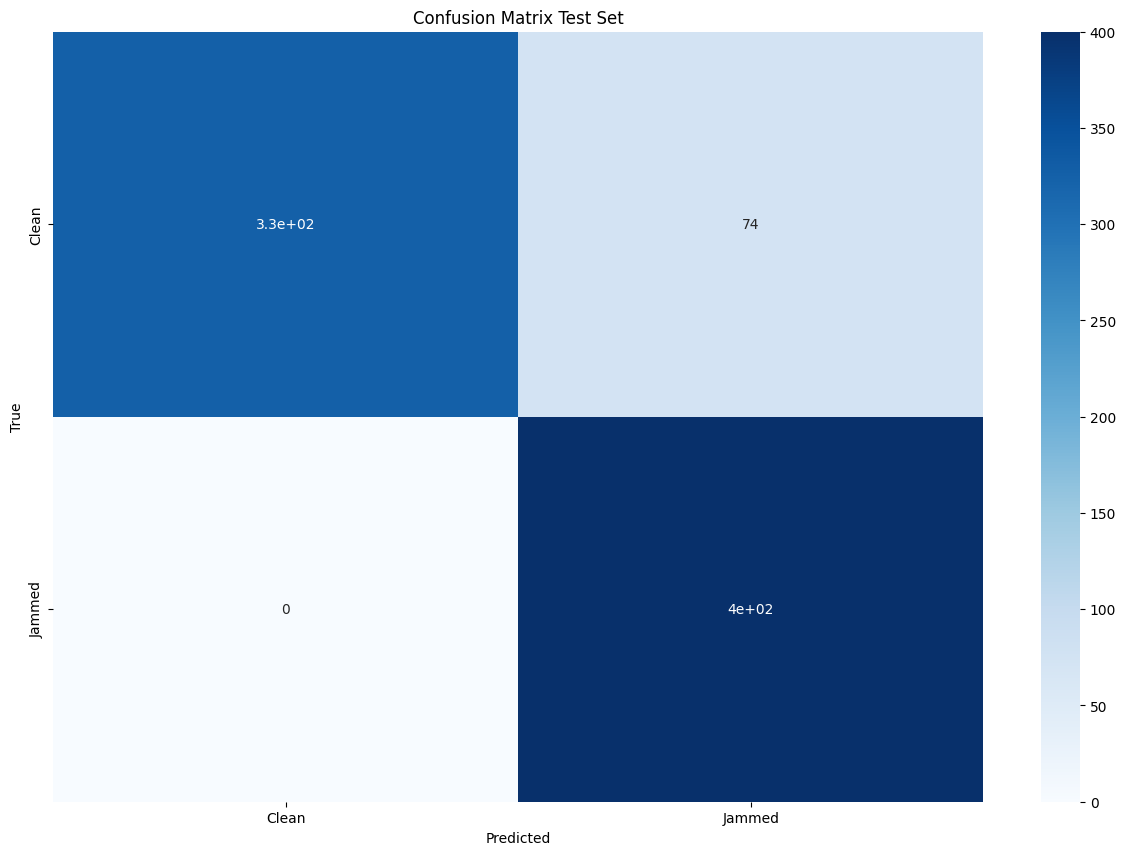

In [29]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold